<h1 style="property:value; background-color:skyblue;" align="center"> TS Forecasting Methods

In [1]:
# basic libraries
import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import plotly.io as pio
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
from warnings import catch_warnings, filterwarnings
from statsmodels.tsa.seasonal import STL
from pmdarima.arima import auto_arima, ARIMA
import statsmodels.api as sm
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tsa.api import ExponentialSmoothing


# set some display options:
pio.templates.default = "plotly_white"
plt.style.use('seaborn-whitegrid')
init_notebook_mode(connected=True)
%matplotlib inline

# helper function
from evaluations import nrmse, mape
from forecast_utils import (neighbor_cells, divide_data, EXP_Smoothing, stat_forecasting, #plot_errors, plot_forecasting 
                            VAR_model, dict_to_dataframe, ts_decomposition, create_acf_pacf, 
                            plot_line, seasonal_decompose, create_corr_plot, DL_Forecaste,
                            plot_hist,test_stationarity, errors_box, dl_train_forecast, ml_forecast)

#### Import the data

In [2]:
path = r''
full_data = np.load(f'{path}/full_data_imputed.npy')

In [3]:
# Exclude the last 10 days !!
full_data = full_data[:(62-10)*144, :, :, :]

<!-- ## Uni-Variant TS Forecasting -->
<!-- For univariant TS we have: -->
#### Forecasting Methods:
 - Statistical methods:
    - Common Approaches:
        - Trend, Seasonal, Residual Decompositions:
            - Seasonal Extraction in ARIMA Time Series (SEATS).
            - Seasonal and Trend decomposition using Loess (STL). 
            - Exponential smoothing:
                - Single Exponential Smoothing, or SES, for univariate data without trend or seasonality.
                - Double Exponential Smoothing for univariate data with support for trends.
                - Triple Exponential Smoothing, or Holt-Winters Exponential Smoothing, with support for both trends and seasonality.(TES)

        - Autoregressive Models (AR).
        - Moving Average Models (MA).
    - Box–Jenkins Approaches: 
        - ARIMA.
        - SARIMA.
        
- Machine Learning Methods
    - KNN.
    - SVR.
    - LR.
    - ElasticNet.
    - Lasso.
    
- Deep Learning Methods:
    - MLP.
    - CNN.
    - LSTM.
        
## If time-series has:
- No trend, no seasonality and is stationary:
    - Moving Average
    - Simple exp smoothing
- Trend only:
    - Double exp smoothing (TS must be stationary)
    - ARIMA
- Trend and seasonality:
    - Triple exp smoothing (TS must be stationary)
    - SARIMA
- Trend, seasonality and holiday effects:
    - FbProphet
- Effect of external variables:
    - FbProphet
    - ML models
    - DL models
        - MLP
        - CNN
        - LSTM
        - Conv-LSTM
        
- But SARIMA and Smothing methods have some issues:
    - Good for one step or short term forecasts, but not for long term forecasts
    - Works for uni-variate data with linear relationships
    - Focus on temporal dependence only. It does not consider events like holidays, promotions.

So we can apply seasonal adjustment first before forecasting with statistical methods.<br>

#### Forecasting with decomposition:

Seasonal adjustment or deseasonalization is a statistical method for removing the seasonal component of a time series in order to avoid the effects of seasonal comonent of the TS we can forecast a decomposed version of the data.

This can improve the performance of modeling:

- **Clearer Signal:** Identifying and removing the seasonal component from the time series can result in a clearer relationship
between input and output variables.
- **More Information:** Additional information about the seasonal component of the time series can provide new information to improve model performance.

Steps:
- Apply Seasonal adjustment.
- Forecast the componsents separately:
    - Forecast the seasonal component **S(t)**.
    - Forecast the seasonally adjusted component, **R(t) + T(t)**.<br> 
- Reseasonalize 

Now we have a seasonal stationary TS, and to forecast the seasonally adjusted component, any non-seasonal forecasting method may be used. <br>
    
References:
- <a href="https://otexts.com/fpp2/forecasting-decomposition.html">Forecasting Decomposition</a>
- <a href="https://en.wikipedia.org/wiki/Seasonal_adjustment">Seasonal adjustment</a>
- <a href="https://robjhyndman.com/papers/ComplexSeasonality.pdf">Complex Seasonality</a>
- <a href="https://otexts.com/fpp2/complexseasonality.html">Complex Seasonality</a>

=<!-- <img src="images/Forecasting FlowChart.gif"><a href="https://people.duke.edu/~rnau/411flow.gif">Source</a></img> -->

<h2 align='left'> Dealing only with 9 grids</h2><br><br>
<table align='left'>
    <tr><td><b>GRID Number </b></td>
        <td><b>X Coordinate</b></td>
        <td><b>Y Coordinate</b></td></tr>
    <tr><td> 1</td> <td> 50</td> <td> 56</td> </tr>
    <tr><td> 2</td> <td> 50</td> <td> 57</td> </tr>
    <tr><td> 3</td> <td> 50</td> <td> 58</td> </tr>
    <tr><td> 4</td> <td> 51</td> <td> 56</td> </tr>
    <tr><td> 5</td> <td> 51</td> <td> 57</td> </tr>
    <tr><td> 6</td> <td> 51</td> <td> 58</td> </tr>
    <tr><td> 7</td> <td> 52</td> <td> 56</td> </tr>
    <tr><td> 8</td> <td> 52</td> <td> 57</td> </tr> 
    <tr><td> 9</td> <td> 52</td> <td> 58</td> </tr>    
</table>

<!-- | GRID Number | X Coordinate | Y Coordinate|
| --- | --- | --- |
| 1 | 50 | 56 |
| 2 | 50 | 57 |
| 3 | 50 | 58 |
| 4 | 51 | 56 |
| 5 | 51 | 57 |
| 6 | 51 | 58 |
| 7 | 52 | 56 |
| 8 | 52 | 57 |
| 9 | 52 | 58 | -->

In [5]:
# gathering the data using neighbor_cells
# neighbor cells are zero for univarite
forecast_grids = [(50,56),(50,57),(50,58), 
                  (51,56),(51,57),(51,58), 
                  (52,56),(52,57),(52,58)]

# Fore Univariate forecasting
grids_df = {'Grid(%d,%d)'%(grid[0], grid[1]): neighbor_cells(data=full_data, 
                                                             neighbor_radius=0, 
                                                             cell_center=[grid[0], grid[1]], 
                                                             uni_variant=True)
           for grid in forecast_grids}

# Fore multivariate forecasting
all_df = neighbor_cells(data=full_data, 
                        neighbor_radius=1, 
                        cell_center=(51, 57), 
                        uni_variant=False)

### Forecasting steps:
- TS analysis.
    - Seasonality Test 
        * Single or Multiple seasonalities.
        * Additive or Multiplicative seasonality.
        * Seasonality with even vs. uneven number of periods.
    - Stationarity Test.
    - Correlation Test. (When dealing with data as Panel data)
    
- Apply Seasonal Decomposition.

- Build Forecasting models.

- Compare the performance of these models with and without decomposition.

>### Lets apply these steps to Grid (52,56)

### 1) TS Analysis


### <li>Decomposition:

A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.
<ul>
<li><b>Systematic:</b> Components of the time series that have consistency or recurrence and can be described and modeled.
<li><b>Non-Systematic:</b> Components of the time series that cannot be directly modeled.<br>
A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.
</ul>
These components are defined as follows:
<ul>
<li><b>Trend:</b> The increasing or decreasing value in the series.
<li><b>Seasonality:</b> The repeating short-term cycle in the series.
<li><b>Noise:</b> The random variation in the series.
</ul>

#### 
<img src="images/TS Components.png">

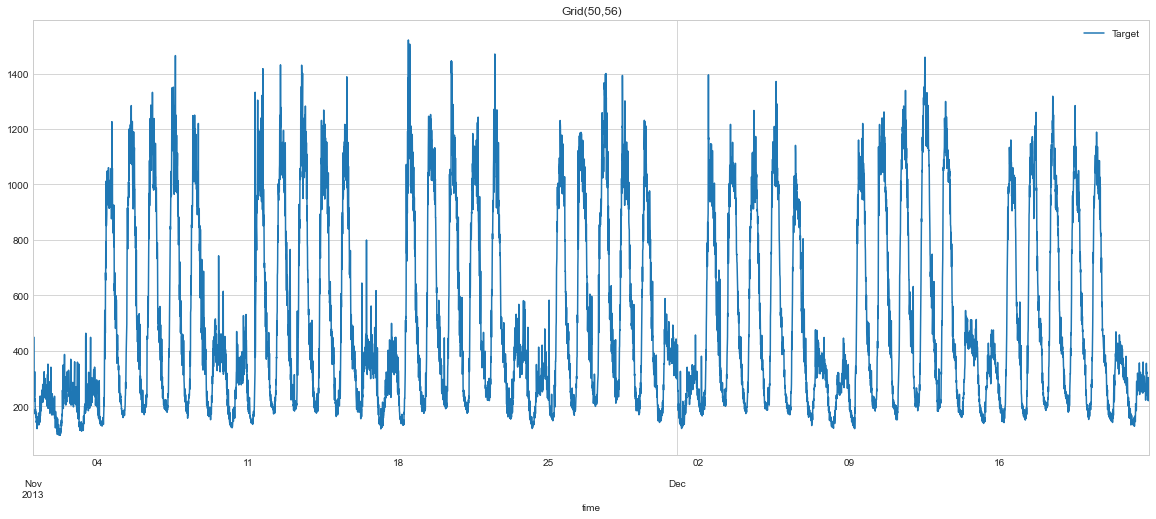

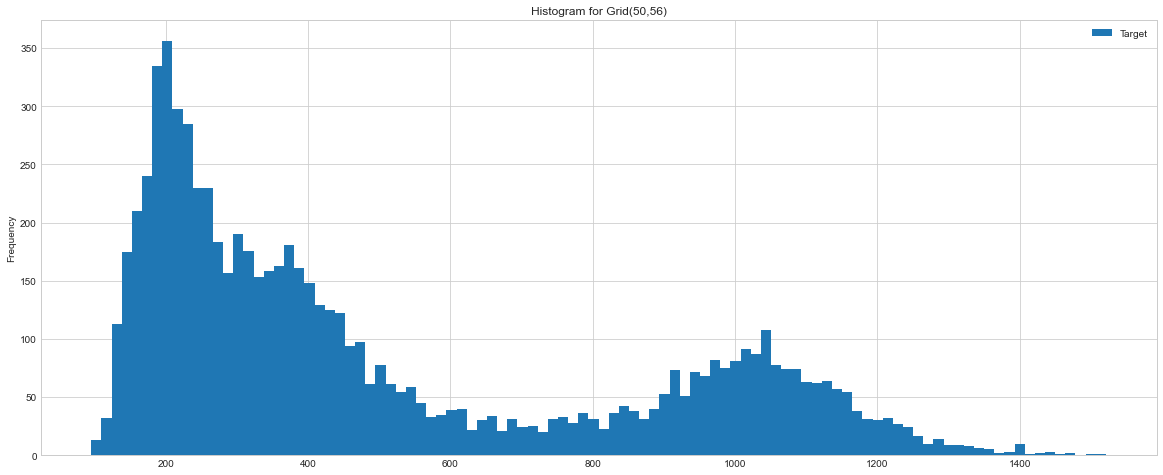

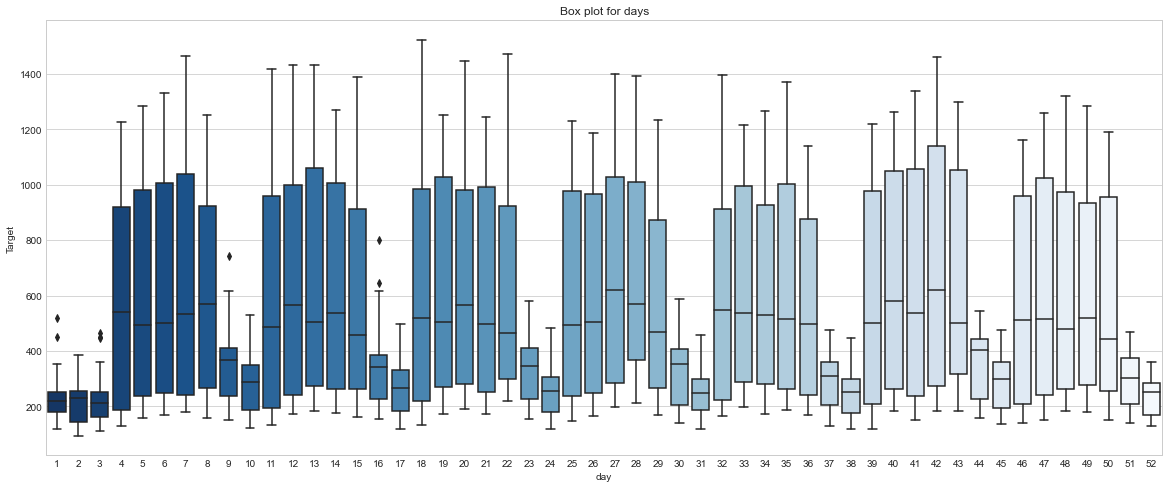

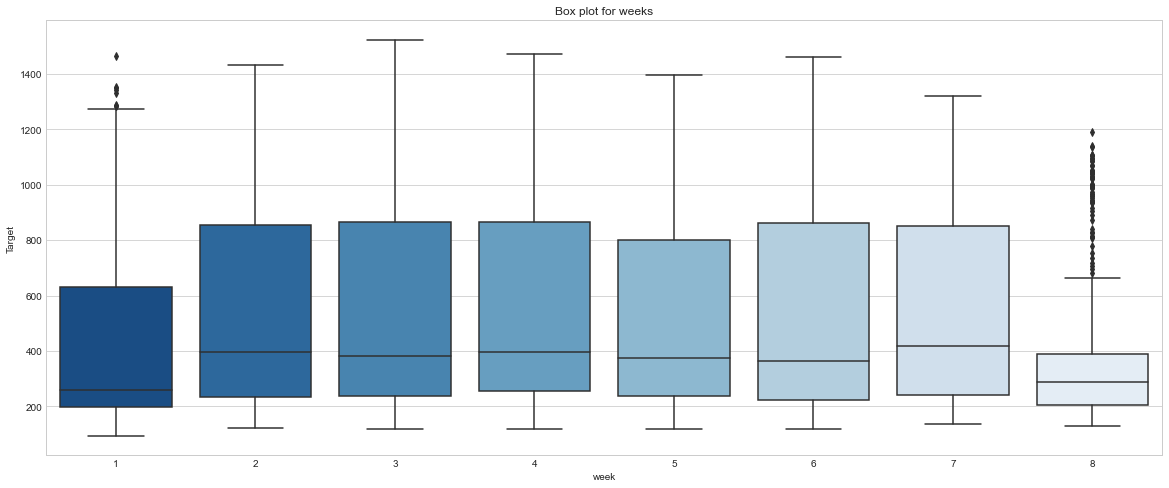

In [5]:
grids_df['Grid(50,56)'].set_index('time').plot(kind='line', figsize=(20,8), title='Grid(50,56)')
grids_df['Grid(50,56)'].set_index('time').plot(kind='hist', bins=100, figsize=(20,8), title='Histogram for Grid(50,56)')
plt.figure(figsize=(20,8))
plt.title('Box plot for days')
sns.boxplot(data=grids_df['Grid(50,56)'].assign(day=lambda x: x.index//(144)+1),
            y='Target', x='day', palette='Blues_r')
plt.figure(figsize=(20,8))
plt.title('Box plot for weeks')
sns.boxplot(data=grids_df['Grid(50,56)'].assign(week=lambda x: x.index//(7*144)+1),
            y='Target', x='week', palette='Blues_r');

### Complex Seasonalities
- Clearly, there are complex seasonalities in the data.
- Let's try daily, weekly decompositions, and analysis the residuals of each one.

### Daily decomposition

##### a) Additive decomposition

In [6]:
_, _, daily_add_resid = ts_decomposition(df=grids_df['Grid(50,56)'], column='Target', 
                                         title='', model='add', period=144, return_results=True)

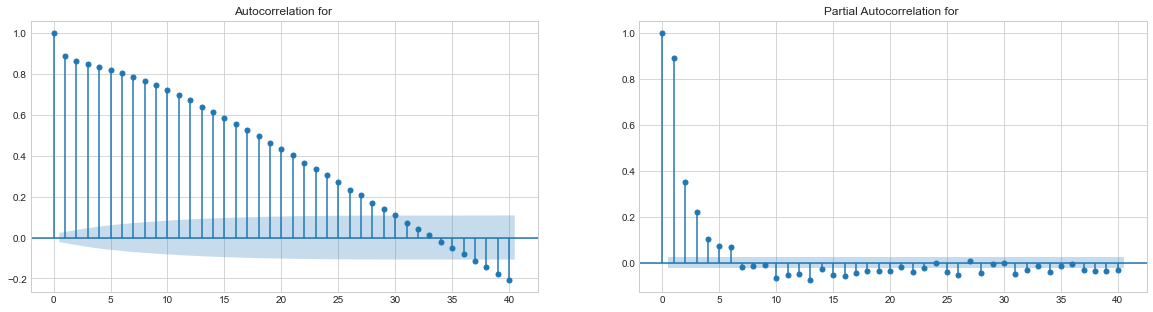

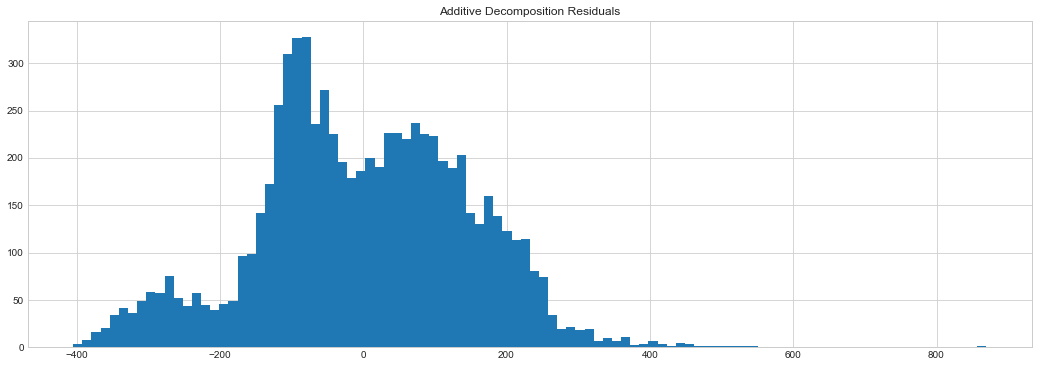

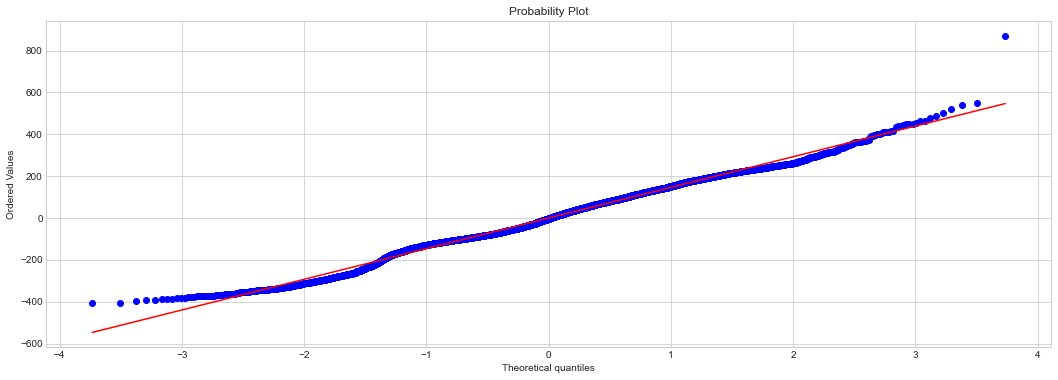

In [7]:
# ACF & PACF Plots
create_acf_pacf(daily_add_resid.dropna(), '')
# Histogram Plot
plt.figure(figsize=(18,6))
plt.title('Additive Decomposition Residuals')
plt.hist(daily_add_resid.dropna(), bins=100)
# Q-Plot
plt.figure(figsize=(18,6))
scipy.stats.probplot(daily_add_resid.dropna(), dist='norm', plot=plt);

#### b) Multiplicative decomposition

In [8]:
_, _, daily_mul_resid = ts_decomposition(df=grids_df['Grid(50,56)'], column='Target', 
                                   title='', model='mul', period=144, return_results=True)

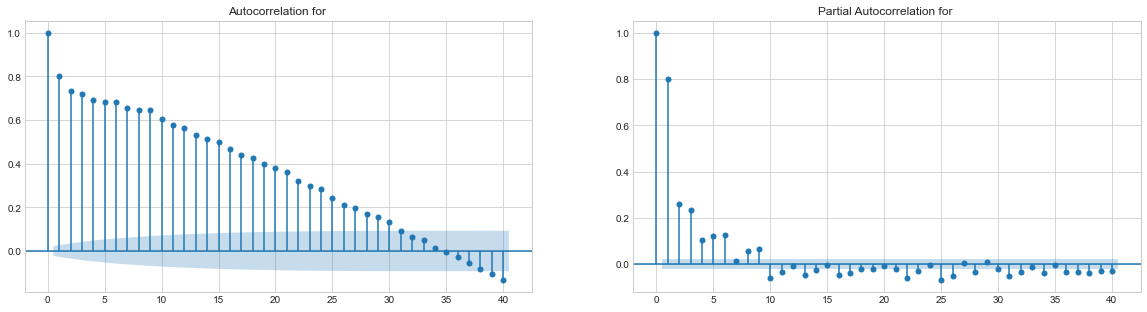

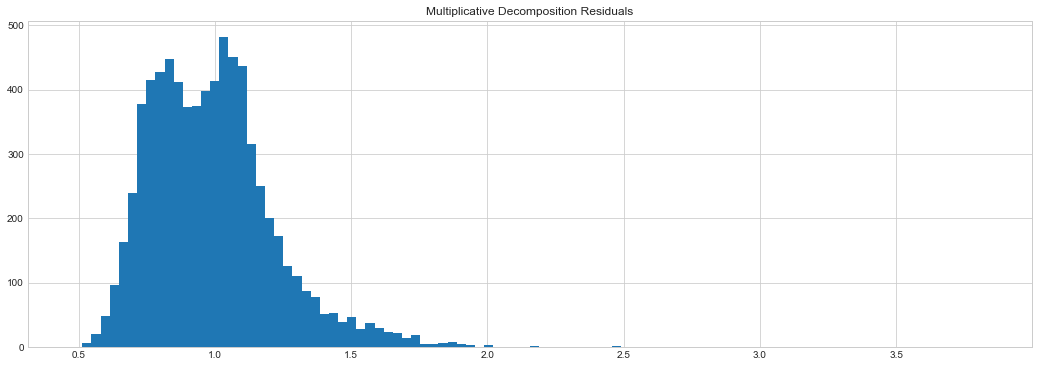

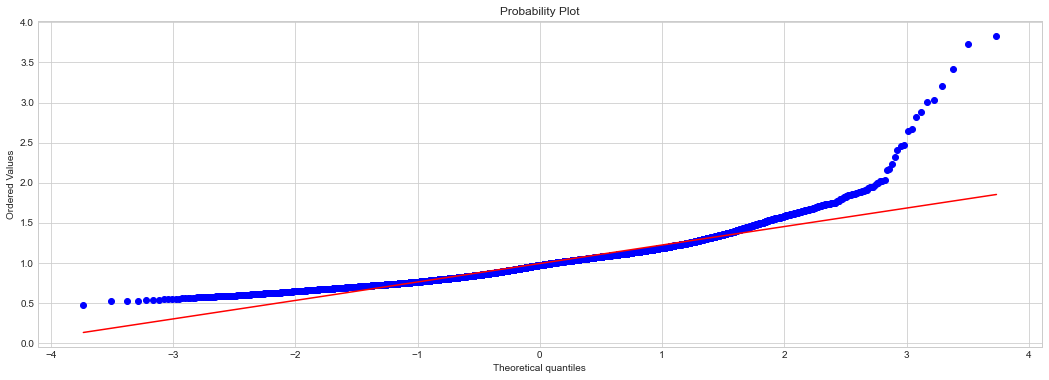

In [9]:
# ACF & PACF Plots
create_acf_pacf(daily_mul_resid.dropna(), '')
# Histogram Plot
plt.figure(figsize=(18,6))
plt.title('Multiplicative Decomposition Residuals')
plt.hist(daily_mul_resid.dropna(), bins=100)
# Q-Plot
plt.figure(figsize=(18,6))
scipy.stats.probplot(daily_mul_resid.dropna(), dist='norm', plot=plt);

### Weekly decomposition

##### a) Additive decomposition

In [10]:
_, _, weekly_add_resid = ts_decomposition(df=grids_df['Grid(50,56)'], column='Target', 
                                          title='', model='add', period=7*144, return_results=True)

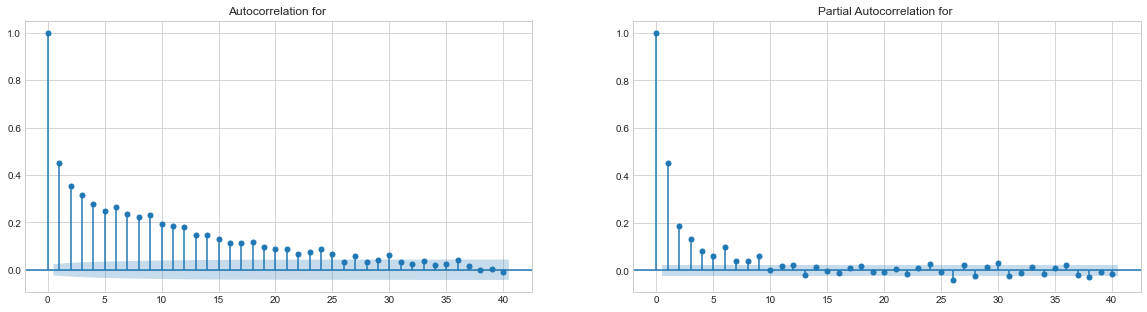

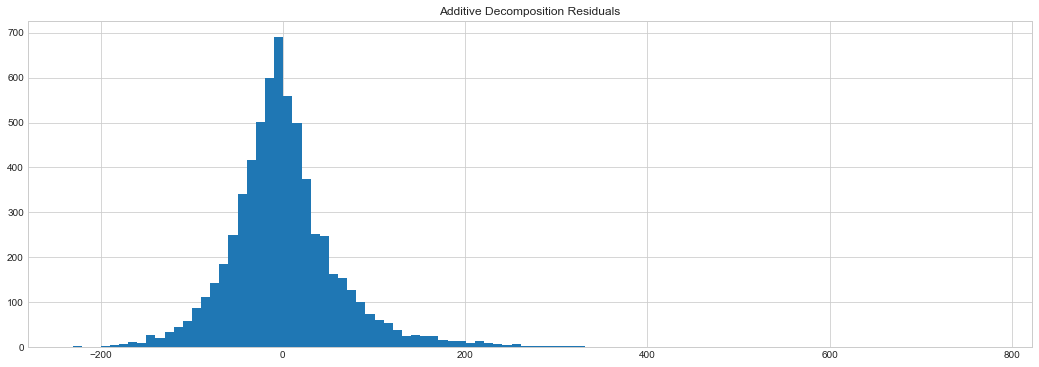

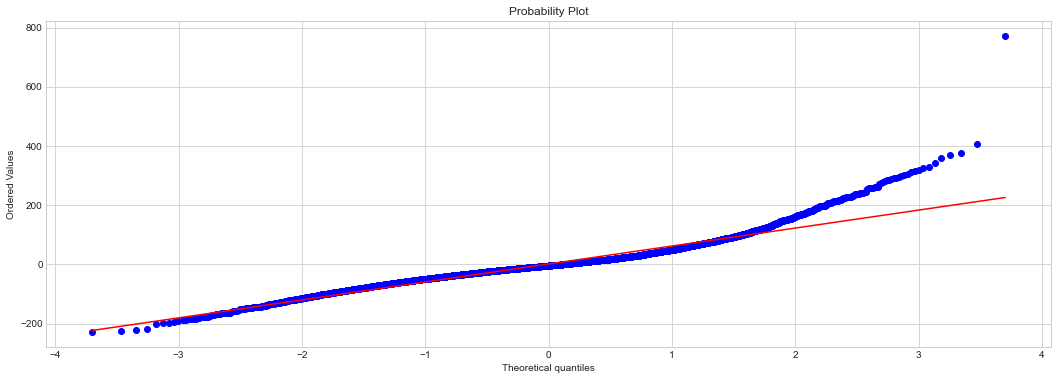

In [11]:
# ACF & PACF Plots
create_acf_pacf(weekly_add_resid.dropna(), '')
# Histogram Plot
plt.figure(figsize=(18,6))
plt.title('Additive Decomposition Residuals')
plt.hist(weekly_add_resid.dropna(), bins=100)
# Q-Plot
plt.figure(figsize=(18,6))
scipy.stats.probplot(weekly_add_resid.dropna(), dist='norm', plot=plt);

#### b) Multiplicative decomposition

In [12]:
_, _, weekly_mul_resid = ts_decomposition(df=grids_df['Grid(50,56)'], column='Target', 
                                          title='', model='mul', period=7*144, return_results=True)

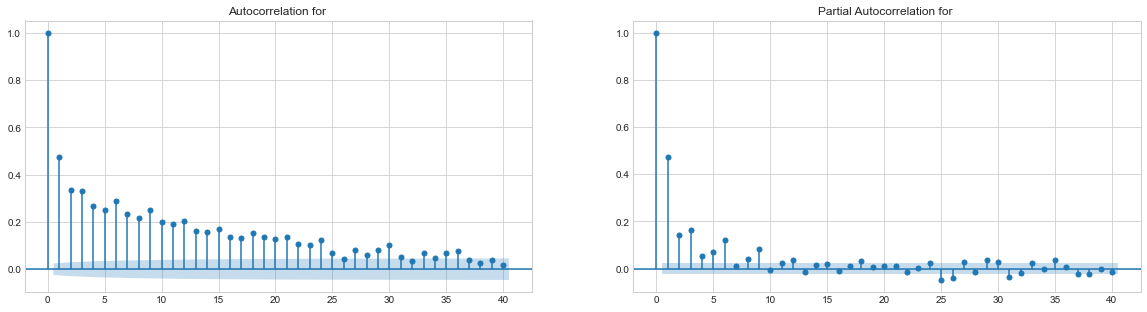

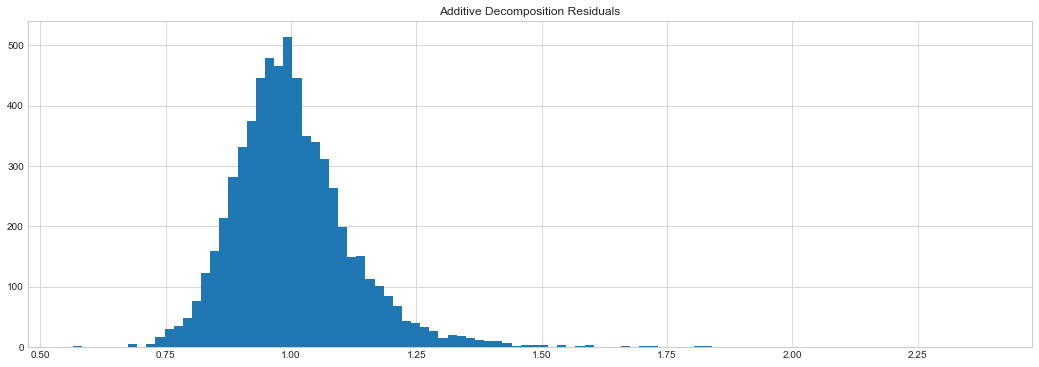

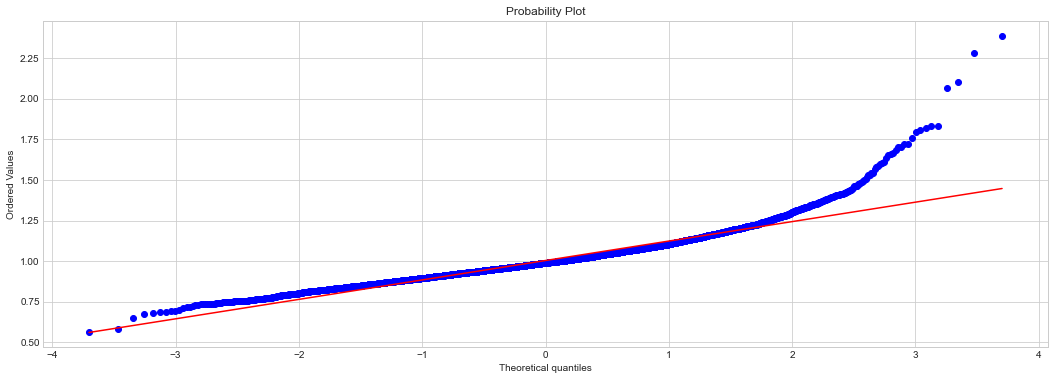

In [13]:
# ACF & PACF Plots
create_acf_pacf(weekly_mul_resid.dropna(), '')
# Histogram Plot
plt.figure(figsize=(18,6))
plt.title('Additive Decomposition Residuals')
plt.hist(weekly_mul_resid.dropna(), bins=100)
# Q-Plot
plt.figure(figsize=(18,6))
scipy.stats.probplot(weekly_mul_resid.dropna(), dist='norm', plot=plt);

>- We found that the residulas of additive weekly decomposition and additive daily decomposition gave us a normally distributed residuals and less corelation appears on the Auto corrolation and partial auto correlation functions. 
> - If we look at the residuals of the multiplicative decomposition closely, it has some pattern left over.
> - The additive decomposition looks quite random so i think it is good !

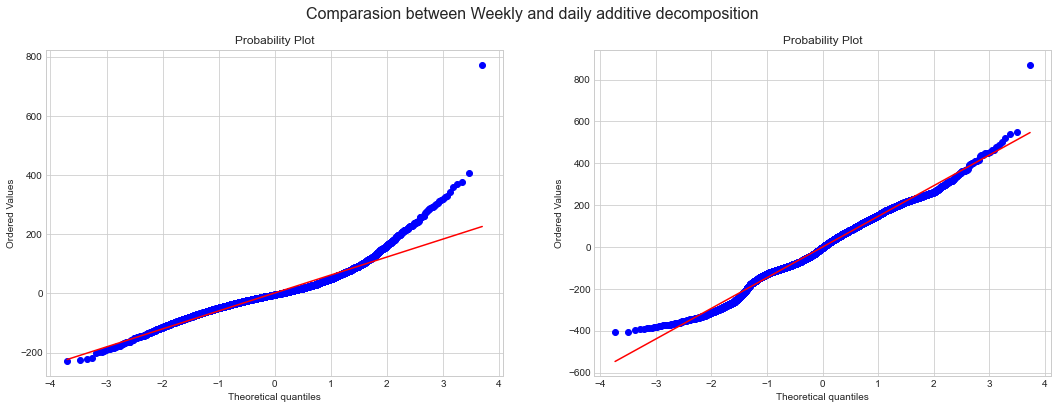

In [14]:
# Q-Plot
fig, ax = plt.subplots(1, 2, figsize=(18,6))
fig.suptitle('Comparasion between Weekly and daily additive decomposition', fontsize=16)
plt.subplot(1,2,1)
scipy.stats.probplot(weekly_add_resid.dropna(), dist='norm', plot=plt)
plt.subplot(1,2,2)
scipy.stats.probplot(daily_add_resid.dropna(), dist='norm', plot=plt);

> ### Now we can see that:
> - QQ plot of daily additive decomposition shows the scatter plots of points in a diagonal line, closely fitting the expected diagonal pattern for a sample from a Gaussian distribution.
> There are a few small deviations, especially at the bottom of the plot, which is to be expected given the small data sample.<br><br>
> - Daily decomposition's residuals gives:
>    - Less correlation appears clearly in ACF & PACF plots.
>    - Distribution closer to normal distribution.(Mesocratic)<br><br>
> - So ideally, additive decomposition for daily should be preferred for this particular grid(TS).

### <li>Stationarity

Most time-series models assume that the underlying time-series data is **stationary**.  This assumption gives us some nice statistical properties that allow us to use various models for forecasting.

**Stationarity** is a statistical assumption that a time-series has:
*   **Constant mean**
*   **Constant variance**
*   **Autocovariance does not depend on time**

More simply put, if we are using past data to predict future data, we should assume that the data will follow the same general trends and patterns as in the past.  This general statement holds for most training data and modeling tasks.
Sometimes we need to transform the data in order to make it stationary.<br>We can check stationarity using these techniques:

**Testing the stationarity:**
- Rolling mean and standard deviation and look if they are changing over time. 
- Apply Dickey-Fuller test or KPSS test, and see if we can reject the null hypothesis (that the time series is stationary)
- Dickey-Fuller Test:
    - Null Hypothesis: Time Series is stationary. It gives a time-dependent trend.
    - Alternate Hypothesis: Time Series is non-stationary. In another term, the series doesn’t depend on time.
    - ADF or t Statistic < critical values: Accept the null hypothesis. Time series is stationary.
    - ADF or t Statistic > critical values: Failed to reject the null hypothesis. The time series is non-stationary

Lets try rolling mean & std 
- Using a smaller window size increases the sensitivity to changes in the underlying process from which we are sampling.

- Using a smaller window size is increases noise due to small sample size.

##### We will use window size equal to one week. (7*144)

===>Results of Dickey-Fuller Test for Target:

Test Statistic                -1.404337e+01
p-value                        3.273293e-26
# Lags Used                    3.600000e+01
Number of Observations Used    7.451000e+03
Critical Value (1%)           -3.431228e+00
Critical Value (5%)           -2.861928e+00
Critical Value (10%)          -2.566977e+00
dtype: float64
Reject Ho ---> Time Series is Stationary


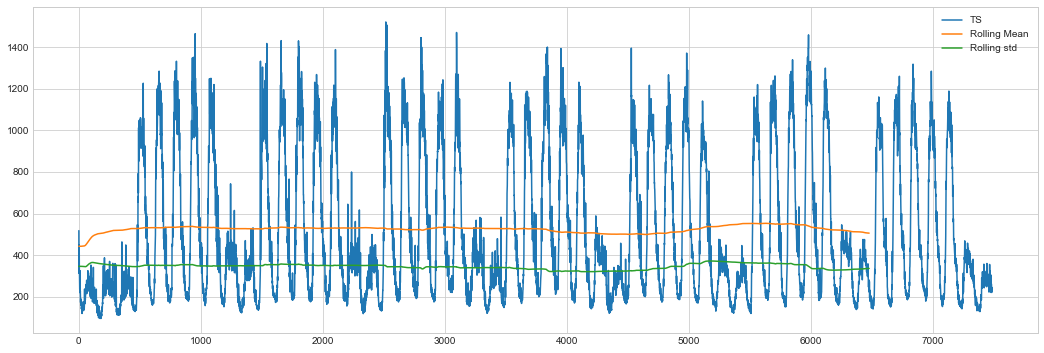

In [15]:
test_stationarity(grids_df['Grid(50,56)'], 'Target', 7*144, title='', ret_values=None)

><b>Rolling std & mean are `time-invariant` !

### <li>Correlation
- **ACF:** A mathematical representation of the degree of similarity between a given time series and the lagged version of itself over successive time intervals. In other words, instead of calculating the correlation between two different series, we calculate the correlation of the series with an “x” unit lagged version (x∈N) of itself. It describes how well the present value of the series is related with its past values.
<img src='images/ACF.png'></img><br><br>
<ul>
<li> r(t) = The time series sorted in ascending order
<li> r(t-k) = The same time series as above but shifted by K units (in our case k=3)
<li> r_bar = Average of the original time series</li>
</ul><br>
- **PACF:** Summarizes the relationship between observations in TS with observations at previous time steps, but with relationships of the intervening observations are removed.<br><br>
So, ACF measures the accumalated affects past lags have on the current value, while PACF measures the direct affect.<br><br>
- The blue area represents Significance

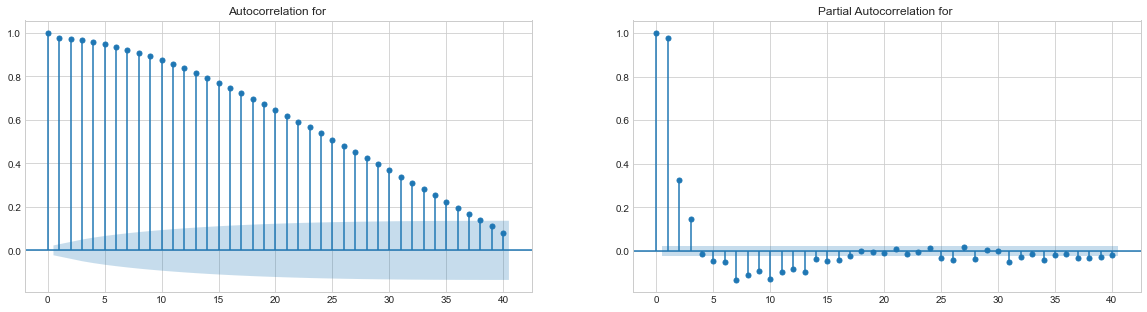

In [16]:
# create_corr_plot(grids_df['Grid(50,58)'].set_index('time'), series_name='Grid(50,56)', plot_pacf=False)
# create_corr_plot(grids_df['Grid(50,58)'].set_index('time'), series_name='Grid(50,56)', plot_pacf=True)
create_acf_pacf(grids_df['Grid(50,56)'].set_index('time'))

#### For ACF:
- Most of spikes are significant.
- All of them are between (1.0 - 0.1).

It shows that the effects are decaying slowly over time, that means that future values of the series are correlated heavily by past values.<br>
The more lags we include, the better the model will fit the data set we feed.

#### For PACF:
- Coefficient in different size.
- Ther're coefficients are neg(-).
- Lags drop away rapidly after 12 lags.
- Ther're coefficients are not significant.(Farest Coefficient)

I think it will be reasonable if we take 15 lags (80%) into consideration with forecasting !

## Forecasting
We will use the sliding window technique with shifting window has the size of 30 days (4320 steps) and forecasting for 1,2,3,7 Days (144, 288, 432, 1008 steps), and measureing the accuracy of our models by two metrics:
- **Noramalized root mean sqaure error (NRMSE)**
- **Mean absolute percentage error(MAPE)**

#### Sliding Window Forecasting
- Window size = 30 days
    - Forecast one day
    - Forecast two days.
    - Forecast three days.
    - Forecast one week.
<img src='images/sliding_win.jpg'></img>

### 1) Statistical methods


**We will try:**
- ARIMA & STL-ARIMA
- Theta & STL-Theta
- Exponential Smoothing & STL-Exponential Smoothing

In [18]:
window_size = 30
date_iter = (full_data.shape[0]//144) - window_size
day_1 = date_iter - 1

models = ['Theta','STL-Theta',
          'ARIMA','STL-ARIMA',
          'Exponential Smoothing','STL-Exponential Smoothing']

Results = {'Grid(%d,%d)'%(grid[0], grid[1]):
           {'%s'%model : 
            {'Day_1':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1)},
             'Day_2':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-1)},
             'Day_3':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-2)},
             'Week' :{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-6)}}
            for model in models}
           for grid in forecast_grids}

with catch_warnings():
    
    filterwarnings("ignore")
    for grid in forecast_grids:
        print('='*50)            
        print('='*18,' Grid (%d , %d) '%(grid[0], grid[1]),'='*18)
        print('='*50)
        
        # gathering the data for each grid
        df = grids_df['Grid(%d,%d)'%(grid[0], grid[1])]
        
        # iterating over the last 32 days
        for i in range(0, date_iter-1, 1):
            # sliding window
            print(str('='*30).center(50))  
            print('='*20,' Window %d '%(i+1),'='*20)
            print(str('='*30).center(50))         
            
            # divide the data using the sliding window with size of 30 days and shift one day every iteration "i"
            data = divide_data(i, df, day_1)
            
            # decomposition for forecasting with decomposition
            decomposition = STL(data['Training']['Target'], period=144).fit()
            seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid
            # forecast only (trend + noise)
            data['Training']['Seasonal'] = seasonal
            data['Training']['Trend_Noise'] = trend + resid
            
            ###########################################
            # Training the models on the current      #
            #   month (Current window position)       #
            ###########################################
            ###### 1) Without STL ######
            print('==> Without STL <==\n'.center(50))
            # ==> Exponintial Smoothing
            exp_model = ExponentialSmoothing(data['Training']['Target'], trend='add',seasonal='add',seasonal_periods=144).fit()
            print('Exponential Smoothing is done!'.center(50))
            # ==> ARIMA
            arima_model = ARIMA(order=(15,0,5)).fit(data['Training']['Target'])
            print('ARIMA is done!'.center(50))
            # ==> Theta
            theta_model = ThetaModel(data['Training']['Target'], period=144).fit()
            print('Theta is done!\n'.center(50))

            ###### 2) With STL ######
            print('==>  With STL   <==\n'.center(50))
            # ==> STL-Exponintial Smoothing
            args = {'trend':'add', 'seasonal':'add', 'seasonal_periods':144}
            s_exp_model = ExponentialSmoothing(data['Training']['Seasonal'], trend='add',seasonal='add',seasonal_periods=144).fit()
            tn_exp_model = ExponentialSmoothing(data['Training']['Trend_Noise'], trend='add',seasonal='add',seasonal_periods=144).fit()
            print('Exponential Smoothing is done!'.center(50))
            # ==> STL-ARIMA
            s_ARIMA_model = ARIMA(order=(15,0,5)).fit(data['Training']['Seasonal'])
            tn_ARIMA_model = ARIMA(order=(15,0,3)).fit(data['Training']['Trend_Noise'])
            print('ARIMA is done!'.center(50))
            # ==> STL-Theta
            s_Theta_model = ThetaModel(data['Training']['Seasonal'], period=144).fit()
            tn_Theta_model = ThetaModel(data['Training']['Trend_Noise'], period=144).fit()
            print('Theta is done!\n'.center(50))
            
            ######################################
            # Forecasting 1-Day, 2-Day, 3-Day,   #
            # and one Week using trained models  #
            ######################################
            
            print('========== Forecasting  =========='.center(50))
            #### 1) 1-Day forecasting
            print(str('='*30).center(50))            
            print('====== 1-Day ======'.center(50))
            print(str('='*30).center(50),'\n')            
            
            # ==> Exp
            Results = stat_forecasting(exp_model, None, None, i, 'Day_1', 
                                  'Exponential Smoothing', data, Results, 144, grid)
            # ==> STL-Exp
            Results = stat_forecasting(None, s_exp_model, tn_exp_model, i, 'Day_1', 
                                  'STL-Exponential Smoothing', data, Results, 144, grid)
            
            # ==> ARIMA
            Results = stat_forecasting(arima_model, None, None, i, 'Day_1', 
                                  'ARIMA', data, Results, 144, grid)
            # ==> STL-ARIMA
            Results = stat_forecasting(None, s_ARIMA_model, tn_ARIMA_model, i, 'Day_1', 
                                  'STL-ARIMA', data, Results, 144, grid)

            # ==> Theta
            Results = stat_forecasting(theta_model, None, None, i, 'Day_1', 
                                  'Theta', data, Results, 144, grid)
            # ==> STL-Theta
            Results = stat_forecasting(None, s_Theta_model, tn_Theta_model, i, 'Day_1', 
                                  'STL-Theta', data, Results, 144, grid)
            
            #### 2) 2-Day forecasting
            if i < (day_1-1):
                print(str('='*30).center(50))           
                print('====== 2-Day ======'.center(50))
                print(str('='*30).center(50),'\n')            
                # ==> Exp
                Results = stat_forecasting(exp_model, None, None, i, 'Day_2', 
                                      'Exponential Smoothing', data, Results, 2*144, grid)
                # ==> STL-Exp
                Results = stat_forecasting(None, s_exp_model, tn_exp_model, i, 'Day_2', 
                                      'STL-Exponential Smoothing', data, Results, 2*144, grid)

                # ==> ARIMA
                Results = stat_forecasting(arima_model, None, None, i, 'Day_2', 
                                      'ARIMA', data, Results, 2*144, grid)
                # ==> STL-ARIMA
                Results = stat_forecasting(None, s_ARIMA_model, tn_ARIMA_model, i, 'Day_2', 
                                      'STL-ARIMA', data, Results, 2*144, grid)

                # ==> Theta
                Results = stat_forecasting(theta_model, None, None, i, 'Day_2', 
                                      'Theta', data, Results, 2*144, grid)
                # ==> STL-Theta
                Results = stat_forecasting(None, s_Theta_model, tn_Theta_model, i, 'Day_2', 
                                      'STL-Theta', data, Results, 2*144, grid)

            #### 3) 3-Day forecasting
            if i < (day_1-2):  
                print(str('='*30).center(50))            
                print('====== 3-Day ======'.center(50))
                print(str('='*30).center(50),'\n')            
            
                # ==> Exp
                Results = stat_forecasting(exp_model, None, None, i, 'Day_3', 
                                      'Exponential Smoothing', data, Results, 3*144, grid)
                # ==> STL-Exp
                Results = stat_forecasting(None, s_exp_model, tn_exp_model, i, 'Day_3', 
                                      'STL-Exponential Smoothing', data, Results,3*144, grid)

                # ==> ARIMA
                Results = stat_forecasting(arima_model, None, None, i, 'Day_3', 
                                      'ARIMA', data, Results,3*144, grid)
                # ==> STL-ARIMA
                Results = stat_forecasting(None, s_ARIMA_model, tn_ARIMA_model, i, 'Day_3', 
                                      'STL-ARIMA', data, Results,3*144, grid)

                # ==> Theta
                Results = stat_forecasting(theta_model, None, None, i, 'Day_3', 
                                      'Theta', data, Results,3*144, grid)
                # ==> STL-Theta
                Results = stat_forecasting(None, s_Theta_model, tn_Theta_model, i, 'Day_3', 
                                      'STL-Theta', data, Results,3*144, grid)
            
            #### 4) week forecasting
            if i < (day_1-6):
                print(str('='*30).center(50))            
                print('====== Week  ======'.center(50))
                print(str('='*30).center(50),'\n')            
                # Exp
                Results = stat_forecasting(exp_model, None, None, i, 'Week', 
                                      'Exponential Smoothing', data, Results, 7*144, grid)
                # STL-Exp
                Results = stat_forecasting(None, s_exp_model, tn_exp_model, i, 'Week', 
                                      'STL-Exponential Smoothing', data, Results, 7*144, grid)

                # ARIMA
                Results = stat_forecasting(arima_model, None, None, i, 'Week', 
                                      'ARIMA', data, Results, 7*144, grid)
                # STL-ARIMA
                Results = stat_forecasting(None, s_ARIMA_model, tn_ARIMA_model, i, 'Week', 
                                      'STL-ARIMA', data, Results, 7*144, grid)

                # Theta
                Results = stat_forecasting(theta_model, None, None, i, 'Week', 
                                      'Theta', data, Results, 7*144, grid)
                # STL-Theta
                Results = stat_forecasting(None, s_Theta_model, tn_Theta_model, i, 'Week', 
                                      'STL-Theta', data, Results, 7*144, grid)

==================  Grid (50 , 56)  ==================
====================  Window 1  ====================
               ==> Without STL <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
               ==>  With STL   <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
        ========== Forecasting  ==========        
               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

====================  Window 2  ====================
               ==> Without STL <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Th


               ====== Week  ======                

====================  Window 8  ====================
               ==> Without STL <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
               ==>  With STL   <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
        ========== Forecasting  ==========        
               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

====================  Window 9  ====================
               ==> Without STL <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Thet

          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
               ==>  With STL   <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
        ========== Forecasting  ==========        
               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

====================  Window 16  ====================
               ==> Without STL <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
               ==>  With STL   <==
               
          Exponential Smoothing is done!          
                  ARIMA 

               ====== 3-Day ======                

====================  Window 19  ====================
               ==> Without STL <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
               ==>  With STL   <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
        ========== Forecasting  ==========        
               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

====================  Window 20  ====================
               ==> Without STL <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
               ==>  W

#### <h3 align='center'>I think it will be nice if we orginaize the results of each stage in this structure !</h3>
<img src="images/Dic_Str.png" >

In [6]:
# a_file = open("Models Results/STAT_Results.pkl", "wb")
# pickle.dump(Results, a_file)
# a_file.close()
file = open("Models Results/STAT_Results.pkl", "rb")
STAT_Results = pickle.load(file)
# print(Results)
file.close()

### Errors Visualization

- ###### Errors Table

In [20]:
grids_stat_errors = dict_to_dataframe(STAT_Results, forecast_grids)

In [21]:
pd.set_option('display.float_format','{:0.6}'.format)
grids_stat_errors.sort_values(by=('Week','MAPE'), ascending=True)

1-Day                             2-Day  \
                                      MAPE            NRMSE             MAPE   
Theta                      0.4024 ± 0.3873  0.5464 ± 0.4569   0.398 ± 0.2999   
Stl-Theta                   0.4267 ± 0.443  0.5054 ± 0.5408  0.4121 ± 0.3325   
Stl-Arima                    0.6899 ± 0.42  0.5691 ± 0.3916  0.7874 ± 0.4123   
Arima                      0.9439 ± 0.5866  0.6416 ± 0.3655  1.0734 ± 0.5487   
Stl-Exponential Smoothing  0.8588 ± 0.8411  0.8464 ± 0.8262  1.0956 ± 1.2764   
Exponential Smoothing      0.9425 ± 1.1152  0.9896 ± 1.0754  1.5305 ± 2.0826   

                                                      3-Day                   \
                                     NRMSE             MAPE            NRMSE   
Theta                      0.4898 ± 0.2609  0.3999 ± 0.2454  0.4819 ± 0.1995   
Stl-Theta                  0.4283 ± 0.3021    0.41 ± 0.2636   0.4107 ± 0.205   
Stl-Arima                  0.5718 ± 0.2873   0.844 ± 0.3608  0.5829 ± 0.1923   
Arima                       0.636 ± 0.2078  1.1513 ± 0.4958  0.6562 ± 0.1618   
Stl-Exponential Smoothing  0.8705 ± 0.8031  1.4116 ± 1.9782  0.9872 ± 1.1138   
Exponential Smoothing      1.1958 ± 1.3583  2.0712 ± 2.9357  1.4326 ± 1.6809   

                                      Week                   
                                      MAPE            NRMSE  
Theta                      0.3919 ± 0.1769  0.4649 ± 0.1495  
Stl-Theta                  0.4248 ± 0.1756  0.4099 ± 0.0976  
Stl-Arima                    1.0285 ± 0.38  0.6355 ± 0.1338  
Arima                      1.3163 ± 0.4398    0.7177 ± 0.12  
Stl-Exponential Smoothing  2.8172 ± 5.4862  1.5936 ± 2.5143  
Exponential Smoothing      4.8174 ± 8.0924  2.6994 ± 3.9161

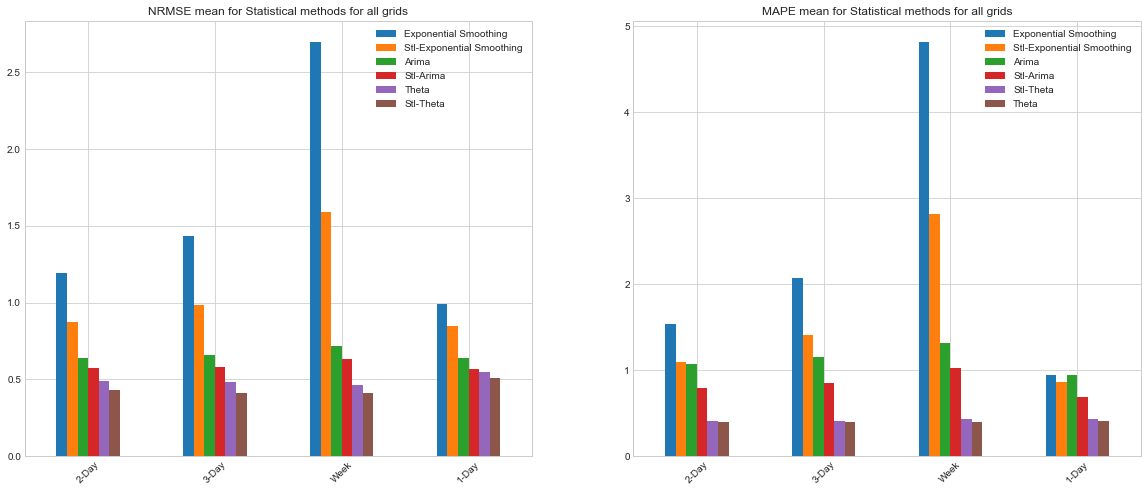

In [22]:
#extract column level
days = set(grids_stat_errors.columns.get_level_values(0))
#extract mean values (mean ± std)
temp = grids_stat_errors.apply(lambda x: x.str.split('±').str[0]).astype(float)
#create a figure
figure, axes = plt.subplots(1, 2)
(
    pd.DataFrame([temp[d]['NRMSE'] for d in days], index=days).T
    .sort_values('Week', ascending=False).T
    .plot(kind='bar',
          grid=True,
          ax=axes[0],
          rot='45',
          layout=(4, 3),
          title='NRMSE mean for Statistical methods for all grids',
          figsize=(20,8))
)
(
    pd.DataFrame([temp[d]['MAPE'] for d in days], index=days).T
    .sort_values('Week', ascending=False).T
    .plot(kind='bar',
          grid=True,
          ax=axes[1],
          rot='45',
          layout=(4, 3),
          title='MAPE mean for Statistical methods for all grids',
          figsize=(20,8))
);

###### Box plot for Grid's Errors

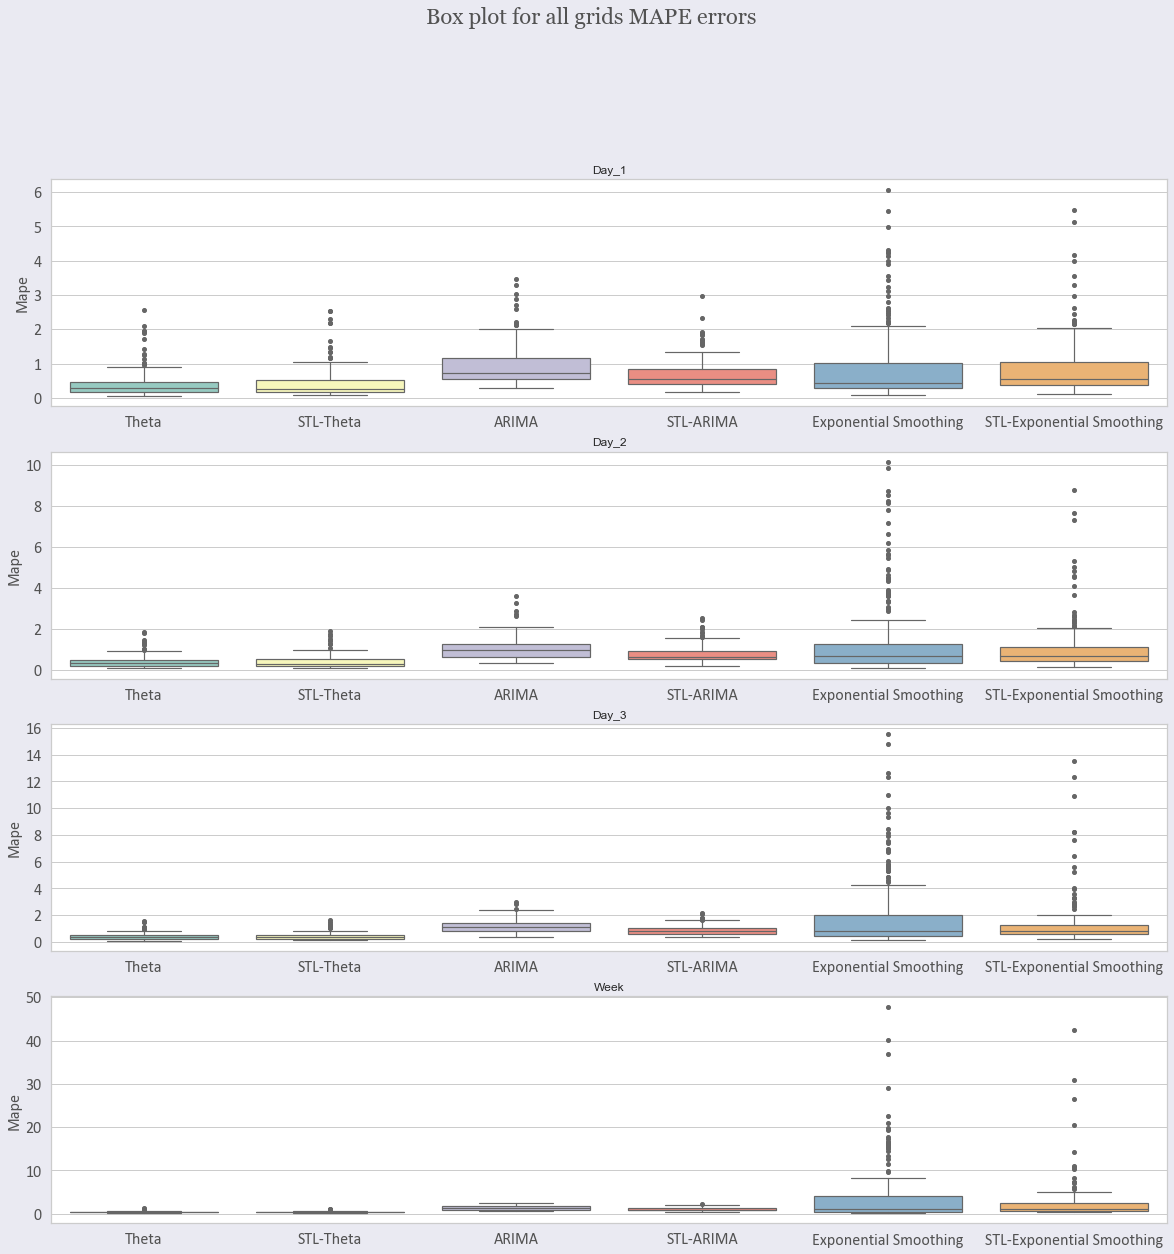

In [23]:
errors_box(STAT_Results, 'mape')

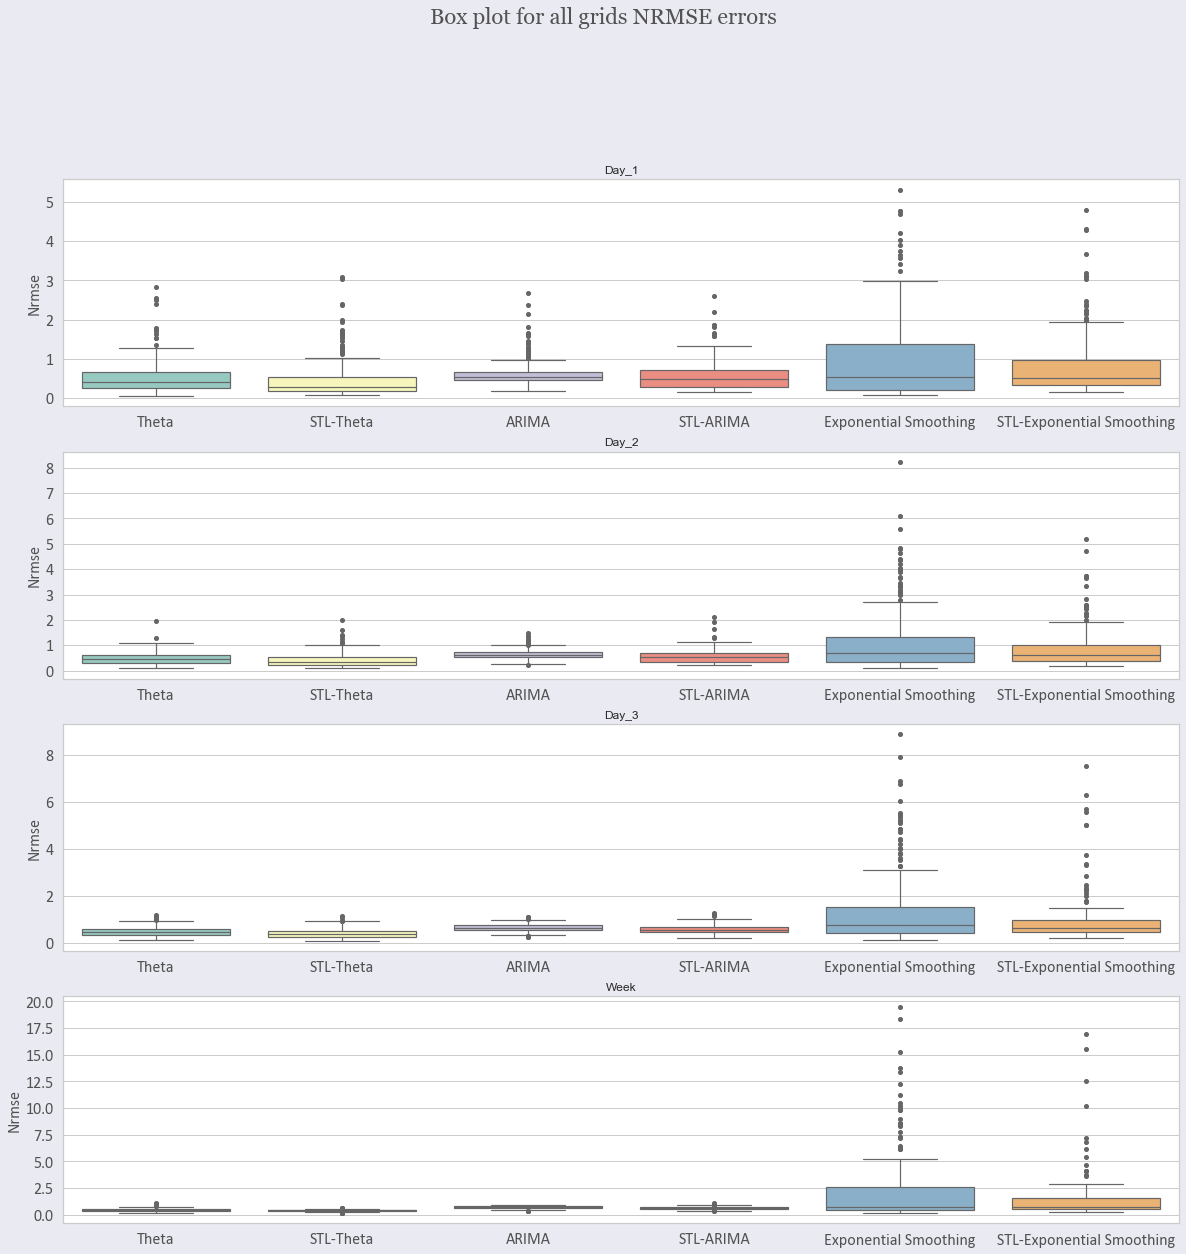

In [24]:
errors_box(STAT_Results, 'nrmse')

#### I think the complex seasonality of the data affects the performance of statistical methods heavily.
#### We can avoid this affects using :
 - Prophet.
 - Dynamic harmonic regression with multiple seasonal periods.
 - Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal. (TBATS)

### 2) Machine Learninig algorithms

Multi-step-ahead forecasts can be produced by ML algorithms by:
- `Recursivly` : 
   - Make a prediction for one time step.
   - Take the prediction, and feed it into the model as an input in order to predict the subsequent time step.
   - This process is repeated until the desired number of steps have been forecasted.
   
   
- `Directly` : 
    - Using a specific model for each horizon. 


- So, I think using `Recursive` method gives higher errors, because we are forecasting some values based on another forecasted values which also has some errors !

- Also, using `Direct` method will have less variance ,but I think it will be more biased, also less of the training data can be used for each model.

So, we can work `Recursivly`!

**We will try:**
- SVR & STL-SVR
- Lasso & STL-Lasso
- ElasticNet & STL-ElasticNet
- KNeighborsRegressor & STL-KNeighborsRegressor
- LinearRegression & STL-LinearRegression

<a href="https://arxiv.org/abs/1909.07872">Sktime</a>

In [26]:
window_size = 30
date_iter = (full_data.shape[0]//144) - window_size
day_1 = date_iter - 1

models = ['knn','stl-knn',
          'svr','stl-svr',
          'lasso','stl-lasso',
          'elasticnet','stl-elasticnet',
          'linearregression','stl-linearregression']

ML_Results = {'Grid(%d,%d)'%(grid[0], grid[1]):
              {'%s'%model : 
               {'Day_1':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1)},
                'Day_2':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-1)},
                'Day_3':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-2)},
                'Week' :{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-6)}}
               for model in models}
              for grid in forecast_grids}

with catch_warnings():
    
    filterwarnings("ignore")
    
    for grid in forecast_grids:
        
        print('='*50)            
        print('='*18,' Grid (%d , %d) '%(grid[0], grid[1]),'='*18)
        print('='*50)
        
        # gathering the data for each grid
        df = grids_df['Grid(%d,%d)'%(grid[0], grid[1])]
        
        # iterating over the last 32 days
        for i in range(0, date_iter-1, 1):
            # sliding window
            print(str('='*30).center(50))  
            print('='*20,' Window %d '%(i+1),'='*20)
            print(str('='*30).center(50),'\n')  
            
            # divide the data
            data = divide_data(i, df, day_1)
            
            ##########################################
            # Training all models to forecaste 1 Day #
            ##########################################
            #### 1-Day forecasting
            print(str('='*30).center(50))           
            print('====== 1-Day ======'.center(50))
            print(str('='*30).center(50),'\n')  
            # KNN
            ML_Results = ml_forecast(i, data, 'KNN', {'n_neighbors':15}, 'Day_1', ML_Results, grid)
            #STL-KNN
            ML_Results = ml_forecast(i, data, 'stl-KNN', {'n_neighbors':15}, 'Day_1', ML_Results, grid)
            # SVR
            ML_Results = ml_forecast(i, data, 'SVR', {}, 'Day_1', ML_Results, grid)
            #STL-SVR
            ML_Results = ml_forecast(i, data, 'stl-SVR', {}, 'Day_1', ML_Results, grid)
            # Lasso
            ML_Results = ml_forecast(i, data, 'Lasso', {'alpha':0.003}, 'Day_1', ML_Results, grid)
            #STL-Lasso
            ML_Results = ml_forecast(i, data, 'stl-Lasso', {'alpha':0.003}, 'Day_1', ML_Results, grid)
            # ElasticNet
            ML_Results = ml_forecast(i, data, 'ElasticNet', {'alpha':0.003}, 'Day_1', ML_Results, grid)
            #STL-ElasticNet
            ML_Results = ml_forecast(i, data, 'stl-ElasticNet', {'alpha':0.003}, 'Day_1', ML_Results, grid)
            # LinearRegression
            ML_Results = ml_forecast(i, data, 'LinearRegression', {}, 'Day_1', ML_Results, grid)
            #STL-LinearRegression
            ML_Results = ml_forecast(i, data, 'stl-LinearRegression', {}, 'Day_1', ML_Results, grid)
            
            ##########################################
            # Training all models to forecaste 2 Days #
            ##########################################
            #### 2-Day forecasting
            if i < (day_1-1):
                print(str('='*30).center(50))          
                print('====== 2-Day ======'.center(50))
                print(str('='*30).center(50),'\n')  
                # KNN
                ML_Results = ml_forecast(i, data, 'KNN', {'n_neighbors':15}, 'Day_2', ML_Results, grid)
                #STL-KNN
                ML_Results = ml_forecast(i, data, 'stl-KNN', {'n_neighbors':15}, 'Day_2', ML_Results, grid)
                # SVR
                ML_Results = ml_forecast(i, data, 'SVR', {}, 'Day_2', ML_Results, grid)
                #STL-SVR
                ML_Results = ml_forecast(i, data, 'stl-SVR', {}, 'Day_2', ML_Results, grid)
                # Lasso
                ML_Results = ml_forecast(i, data, 'Lasso', {'alpha':0.003}, 'Day_2', ML_Results, grid)
                #STL-Lasso
                ML_Results = ml_forecast(i, data, 'stl-Lasso', {'alpha':0.003}, 'Day_2', ML_Results, grid)
                # ElasticNet
                ML_Results = ml_forecast(i, data, 'ElasticNet', {'alpha':0.003}, 'Day_2', ML_Results, grid)
                #STL-ElasticNet
                ML_Results = ml_forecast(i, data, 'stl-ElasticNet', {'alpha':0.003}, 'Day_2', ML_Results, grid)
                # LinearRegression
                ML_Results = ml_forecast(i, data, 'LinearRegression', {}, 'Day_2', ML_Results, grid)
                #STL-LinearRegression
                ML_Results = ml_forecast(i, data, 'stl-LinearRegression', {}, 'Day_2', ML_Results, grid)
                
            ##########################################
            # Training all models to forecaste 3 Day #
            ##########################################
            #### 3-Day forecasting
            if i < (day_1-2):
                print(str('='*30).center(50))  
                print('====== 3-Day ======'.center(50))
                print(str('='*30).center(50),'\n')
                # KNN
                ML_Results = ml_forecast(i, data, 'KNN', {'n_neighbors':15}, 'Day_3', ML_Results, grid)
                #STL-KNN
                ML_Results = ml_forecast(i, data, 'stl-KNN', {'n_neighbors':15}, 'Day_3', ML_Results, grid)
                # SVR
                ML_Results = ml_forecast(i, data, 'SVR', {}, 'Day_3', ML_Results, grid)
                #STL-SVR
                ML_Results = ml_forecast(i, data, 'stl-SVR', {}, 'Day_3', ML_Results, grid)
                # Lasso
                ML_Results = ml_forecast(i, data, 'Lasso', {'alpha':0.003}, 'Day_3', ML_Results, grid)
                #STL-Lasso
                ML_Results = ml_forecast(i, data, 'stl-Lasso', {'alpha':0.003}, 'Day_3', ML_Results, grid)
                # ElasticNet
                ML_Results = ml_forecast(i, data, 'ElasticNet', {'alpha':0.003}, 'Day_3', ML_Results, grid)
                #STL-ElasticNet
                ML_Results = ml_forecast(i, data, 'stl-ElasticNet', {'alpha':0.003}, 'Day_3', ML_Results, grid)
                # LinearRegression
                ML_Results = ml_forecast(i, data, 'LinearRegression', {}, 'Day_3', ML_Results, grid)
                #STL-LinearRegression
                ML_Results = ml_forecast(i, data, 'stl-LinearRegression', {}, 'Day_3', ML_Results, grid)
                
            ###########################################
            # Training all models to forecaste 1 week #
            ###########################################
            #### week forecasting
            if i < (day_1-6):
                print(str('='*30).center(50))  
                print('====== Week  ======'.center(50))
                print(str('='*30).center(50),'\n')  
                #KNN
                ML_Results = ml_forecast(i, data, 'KNN', {'n_neighbors':15}, 'Week', ML_Results, grid)
                #STL-KNN
                ML_Results = ml_forecast(i, data, 'stl-KNN', {'n_neighbors':15}, 'Week', ML_Results, grid)
                # SVR
                ML_Results = ml_forecast(i, data, 'SVR', {}, 'Week', ML_Results, grid)
                #STL-SVR
                ML_Results = ml_forecast(i, data, 'stl-SVR', {}, 'Week', ML_Results, grid)
                # Lasso
                ML_Results = ml_forecast(i, data, 'Lasso', {'alpha':0.003}, 'Week', ML_Results, grid)
                #STL-Lasso
                ML_Results = ml_forecast(i, data, 'stl-Lasso', {'alpha':0.003}, 'Week', ML_Results, grid)
                # ElasticNet
                ML_Results = ml_forecast(i, data, 'ElasticNet', {'alpha':0.003}, 'Week', ML_Results, grid)
                #STL-ElasticNet
                ML_Results = ml_forecast(i, data, 'stl-ElasticNet', {'alpha':0.003}, 'Week', ML_Results, grid)
                # LinearRegression
                ML_Results = ml_forecast(i, data, 'LinearRegression', {}, 'Week', ML_Results, grid)
                #STL-LinearRegression
                ML_Results = ml_forecast(i, data, 'stl-LinearRegression', {}, 'Week', ML_Results, grid)

==================  Grid (50 , 56)  ==================
====================  Window 1  ====================

               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

====================  Window 2  ====================

               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

====================  Window 3  ====================

               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

====================  Window 4  ====================

               ====== 1-Day ======                

               ====== 2-Day ======                

 

               ====== 3-Day ======                

               ====== Week  ======                

====================  Window 3  ====================

               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

====================  Window 4  ====================

               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

====================  Window 5  ====================

               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

====================  Window 6  ====================

               ====== 1-Day ======                

    

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

====================  Window 12  ====================

               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

====================  Window 13  ====================

               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

====================  Window 14  ====================

               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

====================  Window 15  ====================



In [7]:
# a_file = open("ML_Results.pkl", "wb")
# pickle.dump(ML_Results, a_file)
# a_file.close()
file = open("Models Results/ML_Results.pkl", "rb")
ML_Results = pickle.load(file)
# print(Results)
file.close()

### Errors Visualization

###### Errors Table

In [28]:
grids_ml_errors = dict_to_dataframe(ML_Results, forecast_grids, mean_round=5, std_round=4)

In [29]:
pd.set_option('display.float_format', '{:0.9}'.format)
grids_ml_errors.sort_values(by=('Week','MAPE'))

1-Day                               2-Day  \
                                  MAPE             NRMSE              MAPE   
Knn                    0.3541 ± 0.3909  0.47388 ± 0.5311  0.31841 ± 0.3364   
Stl-Knn               0.40965 ± 0.4803  0.52906 ± 0.5884  0.38014 ± 0.4464   
Stl-Lasso             0.41823 ± 0.3737  0.51352 ± 0.4171  0.39261 ± 0.3437   
Stl-Elasticnet        0.41823 ± 0.3737  0.51352 ± 0.4171  0.39261 ± 0.3437   
Stl-Linearregression  0.41823 ± 0.3737  0.51352 ± 0.4171  0.39261 ± 0.3437   
Stl-Svr               0.43949 ± 0.4405  0.51637 ± 0.4862   0.41589 ± 0.407   
Svr                   0.53622 ± 0.2193  0.67748 ± 0.2128  0.53314 ± 0.2216   
Linearregression      0.54641 ± 0.4253  0.51279 ± 0.4077   0.52078 ± 0.402   
Lasso                 0.54682 ± 0.4255  0.51282 ± 0.4078   0.52115 ± 0.402   
Elasticnet            0.54682 ± 0.4255  0.51282 ± 0.4078   0.52115 ± 0.402   

                                                   3-Day                    \
                                 NRMSE              MAPE             NRMSE   
Knn                    0.4129 ± 0.4118   0.30355 ± 0.329   0.39812 ± 0.411   
Stl-Knn               0.47837 ± 0.5006  0.36309 ± 0.4432  0.46178 ± 0.5033   
Stl-Lasso             0.46998 ± 0.3334   0.38186 ± 0.342   0.46241 ± 0.337   
Stl-Elasticnet        0.46998 ± 0.3334   0.38186 ± 0.342   0.46241 ± 0.337   
Stl-Linearregression  0.46998 ± 0.3334   0.38185 ± 0.342   0.46241 ± 0.337   
Stl-Svr               0.47282 ± 0.3958  0.40302 ± 0.4017  0.46168 ± 0.3966   
Svr                   0.68099 ± 0.2139   0.53628 ± 0.221  0.68654 ± 0.2131   
Linearregression      0.46762 ± 0.3151  0.51125 ± 0.4048  0.46185 ± 0.3194   
Lasso                 0.46763 ± 0.3151   0.5116 ± 0.4047  0.46187 ± 0.3193   
Elasticnet            0.46763 ± 0.3151   0.5116 ± 0.4047  0.46187 ± 0.3193   

                                  Week                    
                                  MAPE             NRMSE  
Knn                   0.33732 ± 0.3571  0.43915 ± 0.4383  
Stl-Knn                0.41924 ± 0.482  0.53005 ± 0.5416  
Stl-Lasso              0.4296 ± 0.3663   0.51122 ± 0.356  
Stl-Elasticnet         0.4296 ± 0.3663   0.51122 ± 0.356  
Stl-Linearregression   0.4296 ± 0.3663   0.51122 ± 0.356  
Stl-Svr               0.45298 ± 0.4314  0.51905 ± 0.4194  
Svr                   0.53994 ± 0.2199  0.69068 ± 0.2164  
Linearregression      0.56236 ± 0.4304   0.50303 ± 0.334  
Lasso                 0.56304 ± 0.4301  0.50309 ± 0.3339  
Elasticnet            0.56304 ± 0.4301  0.50309 ± 0.3339

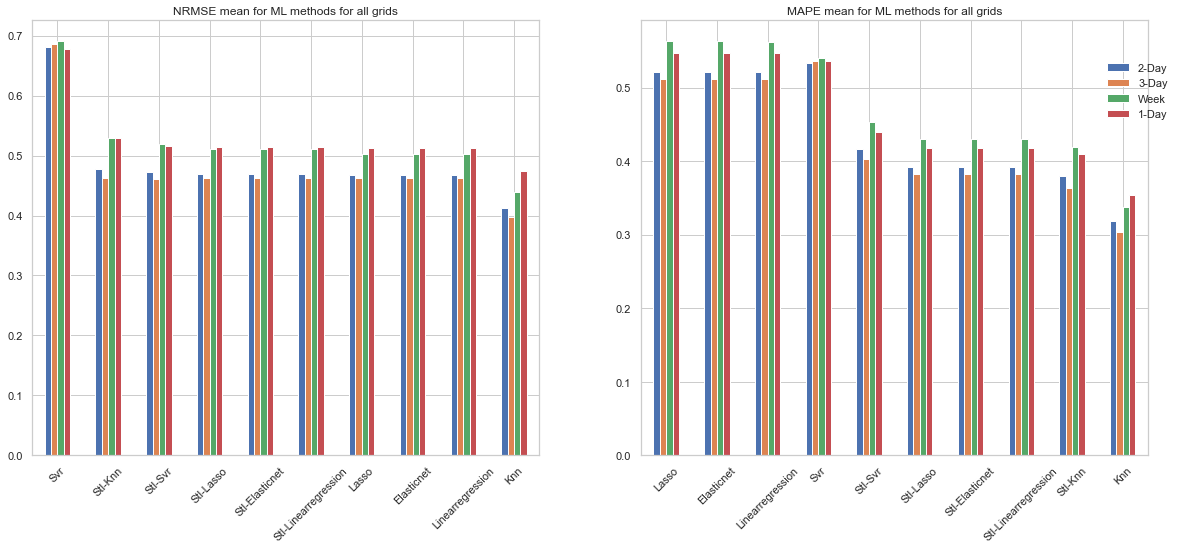

In [30]:
#extract column level
days = set(grids_ml_errors.columns.get_level_values(0))
#extract mean values (mean ± std)
temp = grids_ml_errors.apply(lambda x: x.str.split('±').str[0]).astype(float)
#create a figure
figure, axes = plt.subplots(1, 2)
(
    pd.DataFrame([temp[d]['NRMSE'] for d in days], index=days).T
    .sort_values('Week', ascending=False)
    .plot(kind='bar',
          grid=True,
          ax=axes[0],
          rot='45',
          legend=False,
          layout=(4, 3),
          title='NRMSE mean for ML methods for all grids',
          figsize=(20,8))
)
(
    pd.DataFrame([temp[d]['MAPE'] for d in days], index=days).T
    .sort_values('Week', ascending=False)
    .plot(kind='bar',
          grid=True,
          ax=axes[1],
          rot='45',
          layout=(4, 3),
          title='MAPE mean for ML methods for all grids',
          figsize=(20,8))
    .legend(bbox_to_anchor=(0.9,0.75))
);

###### Box plot for Grid's Errors

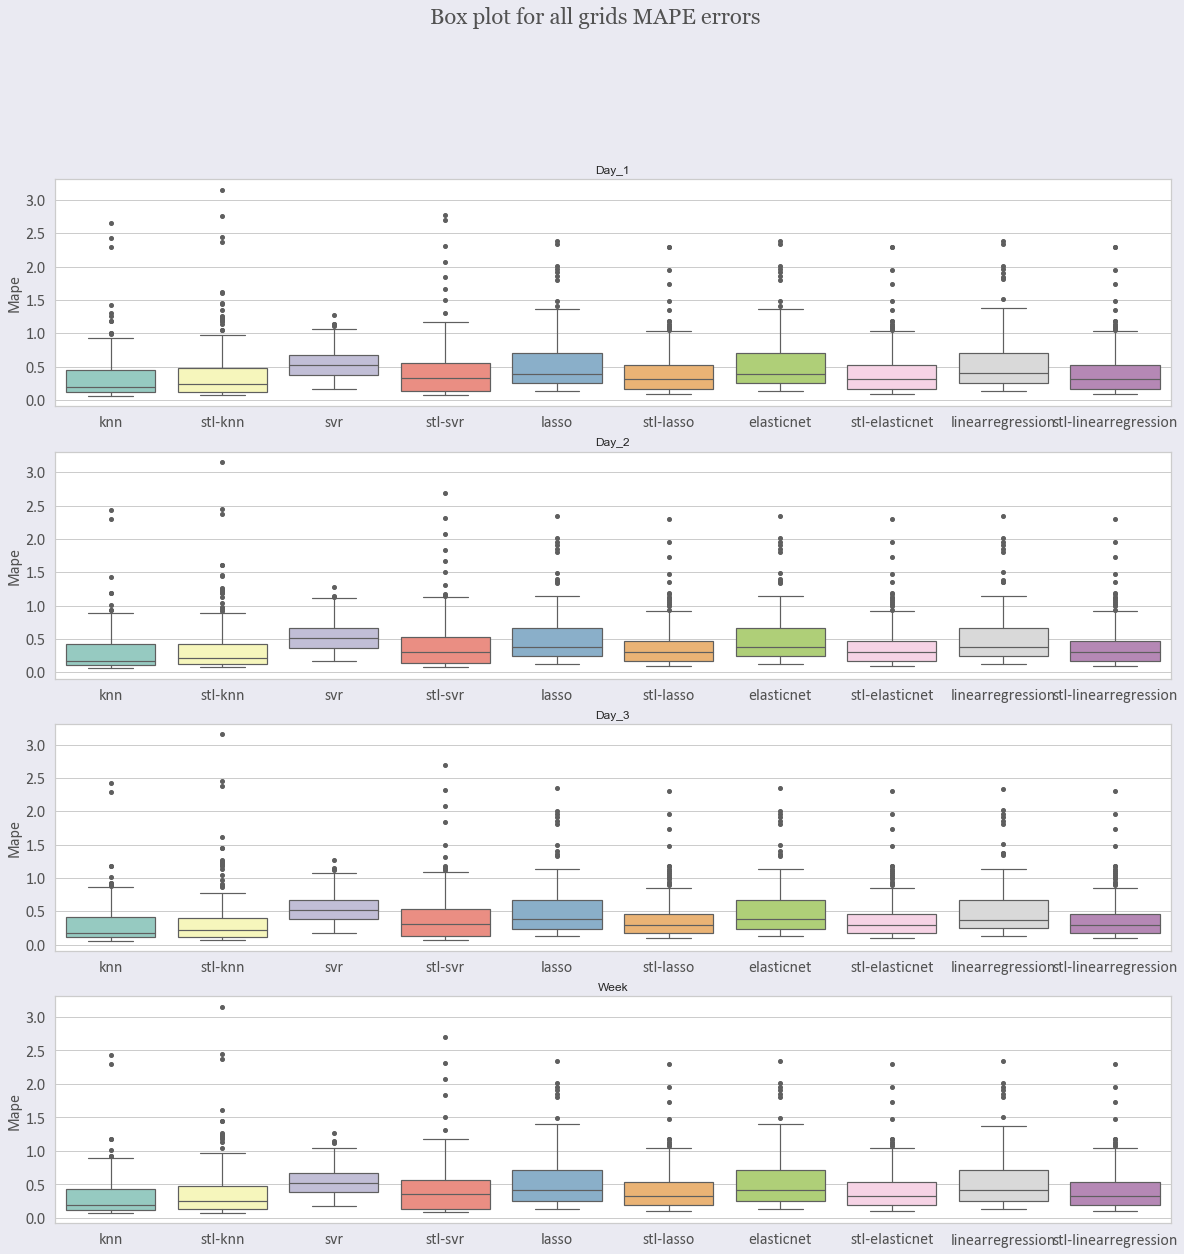

In [31]:
errors_box(ML_Results, 'mape')

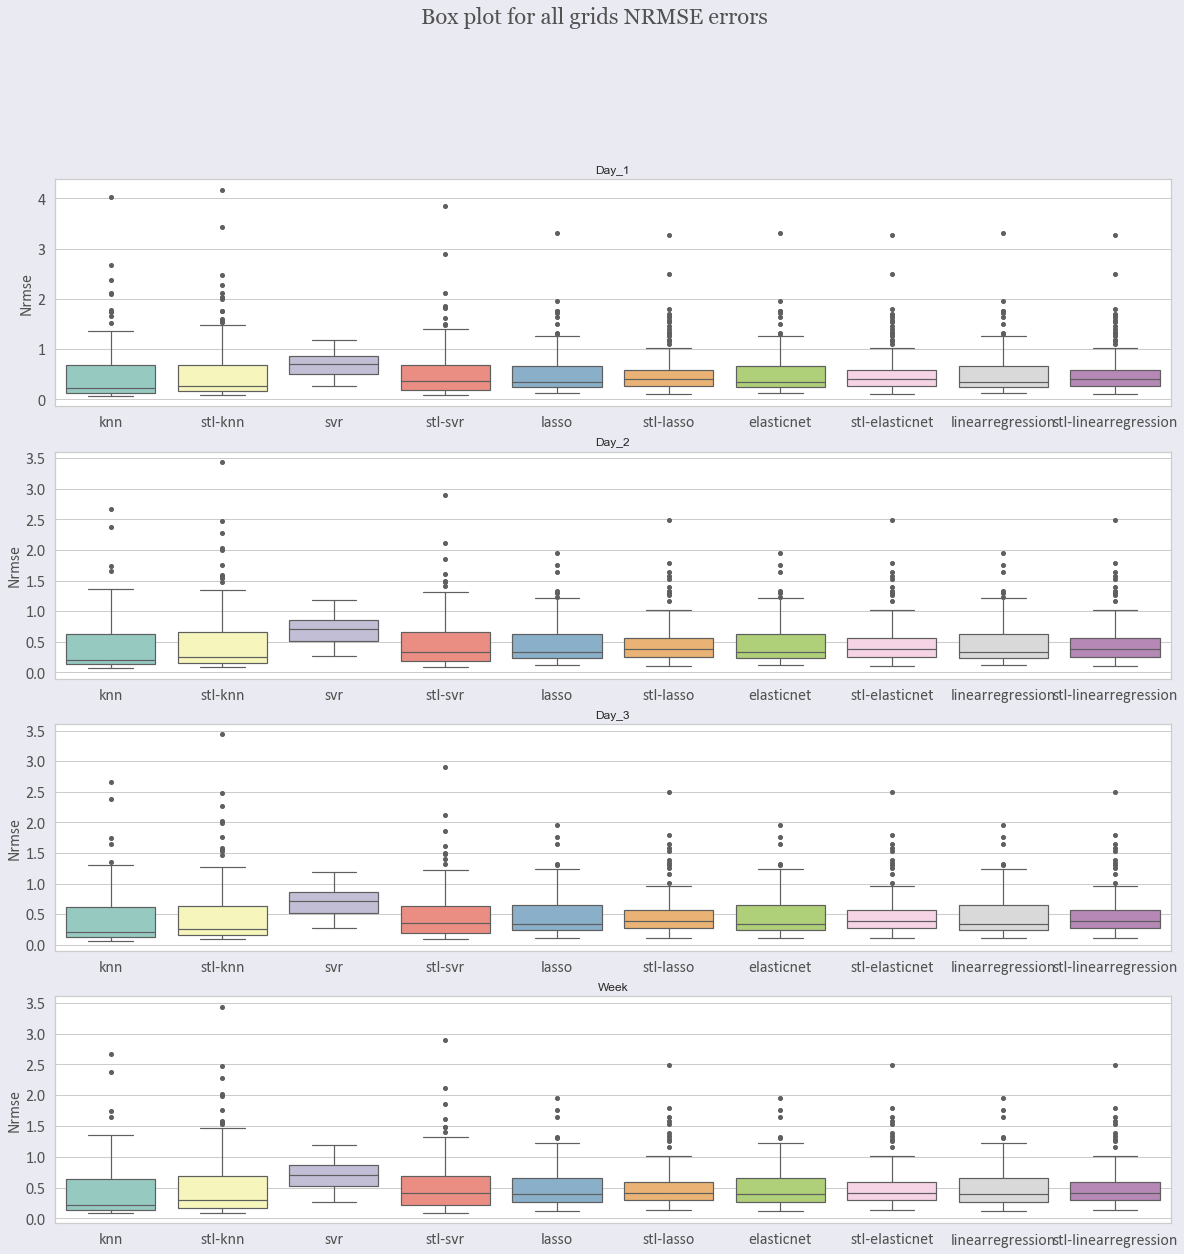

In [32]:
errors_box(ML_Results, 'nrmse')

### Comparison between Statistical & ML results

In [33]:
stat_ml_errors = pd.concat([grids_stat_errors, grids_ml_errors])

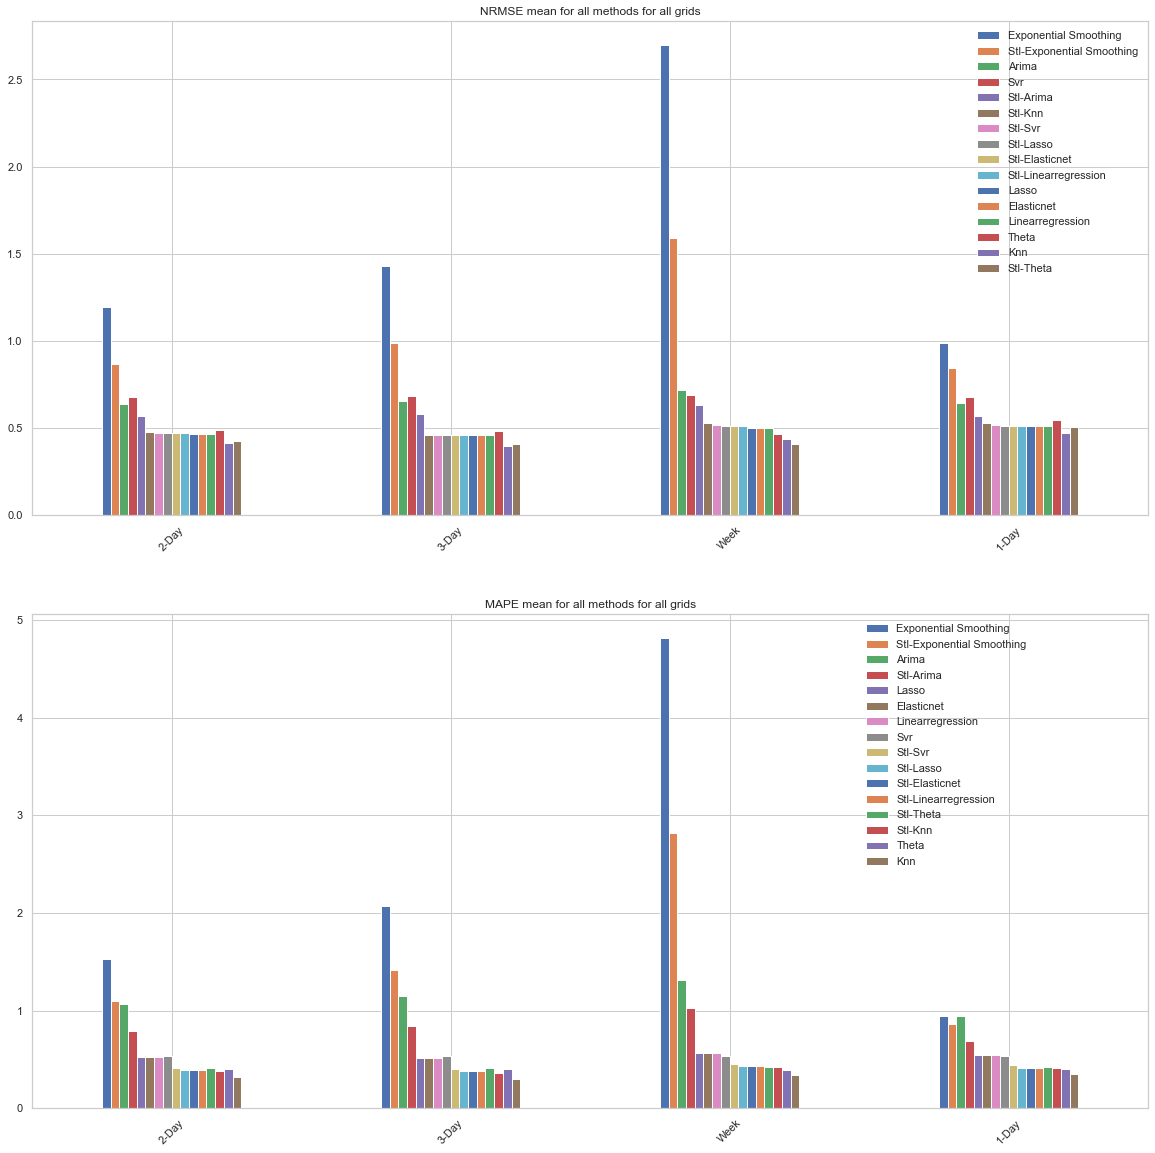

In [34]:
#extract column level
days = set(stat_ml_errors.columns.get_level_values(0))
#extract mean values (mean ± std)
temp = stat_ml_errors.apply(lambda x: x.str.split('±').str[0]).astype(float)
#create a figure
figure, axes = plt.subplots(2, 1, figsize=(20,20))
(
    pd.DataFrame([temp[d]['NRMSE'] for d in days], index=days).T
    .sort_values('Week', ascending=False).T
    .plot(kind='bar',
          grid=True,
          ax=axes[0],
          rot='45',
          layout=(4, 3),
          title='NRMSE mean for all methods for all grids')
)
(
    pd.DataFrame([temp[d]['MAPE'] for d in days], index=days).T
    .sort_values('Week', ascending=False).T
    .plot(kind='bar',
          grid=True,
          ax=axes[1],
          rot='45',
          layout=(4, 3),
          title='MAPE mean for all methods for all grids')
    .legend(bbox_to_anchor=(0.9,1))
);

### 3) Deep Learninig algorithms

**We will try:**
- MLP
- CNN
- LSTM (Vanila, Stacked, Bidirectional LSTM, CNN-LSTM, ConvLSTM).

**I have implemented all types the LSTM, but i wll apply only the `Vanila` type.**<br>
**I will run these methods only for one grid !**

In [9]:
window_size = 30
date_iter = (full_data.shape[0]//144) - window_size
day_1 = date_iter - 1

models = ['mlp','stl-mlp',
          'cnn','stl-cnn',
          'lstm','stl-lstm']

DL_Results = {'Grid(%d,%d)'%(grid[0], grid[1]):
              {'%s'%model : 
               {'Day_1':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1)},
                'Day_2':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-1)},
                'Day_3':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-2)},
                'Week' :{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-6)}}
               for model in models}
              for grid in forecast_grids}

with catch_warnings():
    filterwarnings("ignore")
    
    for grid in [(50,56)]:   
        print('='*50)            
        print('================== Grid (%d , %d) ================'%(grid[0], grid[1]))
        print('='*50)
        
        # gathering the data for each grid
        df = grids_df['Grid(%d,%d)'%(grid[0], grid[1])]
        
        # iterating over the last 32 days
        for i in range(0, date_iter-1, 1):
            # sliding window
            print('        ','='*30,'        ')            
            print('==================== Window %d ===================='%(i+1))
            print('        ','='*30,'        \n')
            
            # divide the data
            data = divide_data(i, df, day_1)
            # decomposition
            decomposition = STL(data['Training']['Target'], period=7*144).fit()
            seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid
            
            # forecast only (trend + noise)
            data['Training']['Seasonal'] = seasonal
            data['Training']['Trend_Noise'] = trend + resid
            
            ##########################################
            # Training all models to forecaste 1 Day #
            ##########################################
            #### 1-Day forecasting
            print(str('='*30).center(50))            
            print('====== 1-Day  ======'.center(50))
            print(str('='*30).center(50),'\n') 
            
            #MLP
            print('====== MLP  ======'.center(50))
            DL_Results = dl_train_forecast(DL_Forecaste(data['Training']['Target'], 'mlp'),
                                           None, None, 'mlp', data, 'Day_1',  i, DL_Results, grid,
                                           dict(lr=0.001, n_steps_in=15, n_steps_out=144, units=128, 
                                                is_scale=True, epochs=100,batch=32, verbose=0))
                    
            print(' ==== STL-MLP =====\n'.center(50))
            s_model = DL_Forecaste(data['Training']['Seasonal'], 'mlp')
            tn_model = DL_Forecaste(data['Training']['Trend_Noise'], 'mlp')
            DL_Results = dl_train_forecast(None, s_model, tn_model, 'stl-mlp', data, 'Day_1', i, DL_Results, grid, None,
                                           dict(lr=0.001, n_steps_in=15, n_steps_out=144, units=128, 
                                                is_scale=True, epochs=100,batch=32, verbose=0),
                                           dict(lr=0.001, n_steps_in=15, n_steps_out=144, units=128, 
                                                is_scale=True, epochs=100,batch=32, verbose=0))
            
            #CNN
            print('====== CNN  ======'.center(50))
            DL_Results = dl_train_forecast(DL_Forecaste(data['Training']['Target'], 'cnn'),
                                           None, None, 'cnn', data, 'Day_1',  i, DL_Results, grid,
                                           dict(n_steps_in=15, n_steps_out=144, units=128, is_scale=True, 
                                                epochs=100, lr=0.001,batch=32, verbose=0), None, None)
                    
            print(' ==== STL-CNN =====\n'.center(50))
            s_model = DL_Forecaste(data['Training']['Seasonal'], 'cnn')
            tn_model = DL_Forecaste(data['Training']['Trend_Noise'], 'cnn')
            model = dl_train_forecast(None, s_model, tn_model, 'stl-cnn', data, 'Day_1', i, DL_Results, grid, None,
                                      dict(n_steps_in=15, n_steps_out=144, units=128, is_scale=True, 
                                           epochs=100, lr=0.001,batch=32, verbose=0),
                                      dict(n_steps_in=15, n_steps_out=144, units=128, is_scale=True,
                                           epochs=100, lr=0.001,batch=32, verbose=0))
            #LSTM
            print('====== LSTM  ======'.center(50))
            DL_Results = dl_train_forecast(DL_Forecaste(data['Training']['Target'], 'lstm', 'vanila'),
                                           None, None, 'lstm', data, 'Day_1',  i, DL_Results, grid,
                                           dict(n_steps_in=15, n_steps_out=144, units=100, is_scale=True, 
                                                epochs=100, lr=0.001, batch=32, verbose=0), None, None)

            print(' ==== STL-LSTM =====\n'.center(50))
            s_model = DL_Forecaste(data['Training']['Seasonal'], 'lstm', 'vanila')
            tn_model = DL_Forecaste(data['Training']['Trend_Noise'], 'lstm', 'vanila')
            model = dl_train_forecast(None, s_model, tn_model, 'stl-lstm', data, 'Day_1', i, DL_Results, grid, None,
                                      dict(n_steps_in=15, n_steps_out=144, units=100, is_scale=True, 
                                           epochs=100, lr=0.001, batch=32, verbose=0),
                                      dict(n_steps_in=15, n_steps_out=144, units=100, is_scale=True,
                                           epochs=100, lr=0.001, batch=32, verbose=0))
            
            ##########################################
            # Training all models to forecaste 2 Day #
            ##########################################
            #### 2-Day forecasting
            if i < (day_1-1):
                print(str('='*30).center(50))            
                print('====== 2-Day  ======'.center(50))
                print(str('='*30).center(50),'\n')
                #MLP
                print('====== MLP  ======'.center(50))
                DL_Results = dl_train_forecast(DL_Forecaste(data['Training']['Target'], 'mlp'),
                                               None, None, 'mlp', data, 'Day_2',  i, DL_Results, grid,
                                               dict(lr=0.001, n_steps_in=25, n_steps_out=2*144, units=128, 
                                                    is_scale=True, epochs=100,batch=32, verbose=0))

                print(' ==== STL-MLP =====\n'.center(50))
                s_model = DL_Forecaste(data['Training']['Seasonal'], 'mlp')
                tn_model = DL_Forecaste(data['Training']['Trend_Noise'], 'mlp')
                DL_Results = dl_train_forecast(None, s_model, tn_model, 'stl-mlp',data, 'Day_2', i,DL_Results,grid,None,
                                               dict(lr=0.001, n_steps_in=25, n_steps_out=2*144, units=128, 
                                                    is_scale=True, epochs=100,batch=32, verbose=0),
                                               dict(lr=0.001, n_steps_in=25, n_steps_out=2*144, units=128, 
                                                    is_scale=True, epochs=128,batch=32, verbose=0))

                #CNN
                print('====== CNN  ======'.center(50))
                DL_Results = dl_train_forecast(DL_Forecaste(data['Training']['Target'], 'cnn'),
                                               None, None, 'cnn', data, 'Day_2',  i, DL_Results, grid,
                                               dict(n_steps_in=25, n_steps_out=2*144, units=128, is_scale=True, 
                                                    epochs=100, lr=0.001, batch=32, verbose=0), None, None)

                print(' ==== STL-CNN =====\n'.center(50))
                s_model = DL_Forecaste(data['Training']['Seasonal'], 'cnn')
                tn_model = DL_Forecaste(data['Training']['Trend_Noise'], 'cnn')
                model = dl_train_forecast(None, s_model, tn_model, 'stl-cnn', data, 'Day_2', i, DL_Results, grid, None,
                                          dict(n_steps_in=25, n_steps_out=2*144, units=128, is_scale=True, 
                                               epochs=100, lr=0.001, batch=32, verbose=0),
                                          dict(n_steps_in=25, n_steps_out=2*144, units=128, is_scale=True,
                                               epochs=100, lr=0.001, batch=32, verbose=0))
                #LSTM
                print('====== LSTM  ======'.center(50))
                DL_Results = dl_train_forecast(DL_Forecaste(data['Training']['Target'], 'lstm', 'vanila'),
                                               None, None, 'lstm', data, 'Day_2',  i, DL_Results, grid,
                                               dict(n_steps_in=25, n_steps_out=2*144, units=100, is_scale=True, 
                                                    epochs=100, lr=0.001, batch=32, verbose=0), None, None)

                print(' ==== STL-LSTM =====\n'.center(50))
                s_model = DL_Forecaste(data['Training']['Seasonal'], 'lstm', 'vanila')
                tn_model = DL_Forecaste(data['Training']['Trend_Noise'], 'lstm', 'vanila')
                model = dl_train_forecast(None, s_model, tn_model, 'stl-lstm', data, 'Day_2', i, DL_Results, grid, None,
                                          dict(n_steps_in=25, n_steps_out=2*144, units=100, is_scale=True, 
                                               epochs=100, lr=0.001, batch=32, verbose=0),
                                          dict(n_steps_in=25, n_steps_out=2*144, units=100, is_scale=True,
                                               epochs=100, lr=0.001, batch=32, verbose=0))
             
            ##########################################
            # Training all models to forecaste 3 Day #
            ##########################################
            #### 3-Day forecasting
            if i < (day_1-2):
                print(str('='*30).center(50))            
                print('====== 3-Day  ======'.center(50))
                print(str('='*30).center(50),'\n')
                #MLP
                print('====== MLP  ======'.center(50))
                DL_Results = dl_train_forecast(DL_Forecaste(data['Training']['Target'], 'mlp'),
                                               None, None, 'mlp', data, 'Day_3',  i, DL_Results, grid,
                                               dict(lr=0.001, n_steps_in=25, n_steps_out=3*144, units=128, 
                                                    is_scale=True, epochs=100,batch=32, verbose=0))

                print(' ==== STL-MLP =====\n'.center(50))
                s_model = DL_Forecaste(data['Training']['Seasonal'], 'mlp')
                tn_model = DL_Forecaste(data['Training']['Trend_Noise'], 'mlp')
                DL_Results = dl_train_forecast(None, s_model, tn_model, 'stl-mlp',data, 'Day_3', i,DL_Results,grid,None,
                                               dict(lr=0.001, n_steps_in=25, n_steps_out=3*144, units=128, 
                                                    is_scale=True, epochs=100,batch=32, verbose=0),
                                               dict(lr=0.001, n_steps_in=25, n_steps_out=3*144, units=128, 
                                                    is_scale=True, epochs=128,batch=32, verbose=0))

                #CNN
                print('====== CNN  ======'.center(50))
                DL_Results = dl_train_forecast(DL_Forecaste(data['Training']['Target'], 'cnn'),
                                               None, None, 'cnn', data, 'Day_3',  i, DL_Results, grid,
                                               dict(n_steps_in=25, n_steps_out=3*144, units=128, is_scale=True, 
                                                    epochs=100, lr=0.001, batch=32, verbose=0), None, None)

                print(' ==== STL-CNN =====\n'.center(50))
                s_model = DL_Forecaste(data['Training']['Seasonal'], 'cnn')
                tn_model = DL_Forecaste(data['Training']['Trend_Noise'], 'cnn')
                model = dl_train_forecast(None, s_model, tn_model, 'stl-cnn', data, 'Day_3', i, DL_Results, grid, None,
                                          dict(n_steps_in=25, n_steps_out=3*144, units=128, is_scale=True, 
                                               epochs=100, lr=0.001, batch=32, verbose=0),
                                          dict(n_steps_in=25, n_steps_out=3*144, units=128, is_scale=True,
                                               epochs=100, lr=0.001, batch=32, verbose=0))
                #LSTM
                print('====== LSTM  ======'.center(50))
                DL_Results = dl_train_forecast(DL_Forecaste(data['Training']['Target'], 'lstm', 'vanila'),
                                               None, None, 'lstm', data, 'Day_3',  i, DL_Results, grid,
                                               dict(n_steps_in=25, n_steps_out=3*144, units=100, is_scale=True, 
                                                    epochs=100, lr=0.001, batch=32, verbose=0), None, None)

                print(' ==== STL-LSTM =====\n'.center(50))
                s_model = DL_Forecaste(data['Training']['Seasonal'], 'lstm', 'vanila')
                tn_model = DL_Forecaste(data['Training']['Trend_Noise'], 'lstm', 'vanila')
                model = dl_train_forecast(None, s_model, tn_model, 'stl-lstm', data, 'Day_3', i, DL_Results, grid, None,
                                          dict(n_steps_in=25, n_steps_out=3*144, units=100, is_scale=True, 
                                               epochs=100, lr=0.001, batch=32, verbose=0),
                                          dict(n_steps_in=25, n_steps_out=3*144, units=100, is_scale=True,
                                               epochs=100, lr=0.001, batch=32, verbose=0))
                
            ###########################################
            # Training all models to forecaste 1 week #
            ###########################################
            #### week forecasting
            if i < (day_1-6):
                print(str('='*30).center(50))            
                print('====== Week  ======'.center(50))
                print(str('='*30).center(50),'\n') 
                #MLP
                print('====== MLP  ======'.center(50))
                DL_Results = dl_train_forecast(DL_Forecaste(data['Training']['Target'], 'mlp'),
                                               None, None, 'mlp', data, 'Week',  i, DL_Results, grid,
                                               dict(lr=0.001, n_steps_in=25, n_steps_out=7*144, units=128, 
                                                    is_scale=True, epochs=100,batch=32, verbose=0))

                print(' ==== STL-MLP =====\n'.center(50))
                s_model = DL_Forecaste(data['Training']['Seasonal'], 'mlp')
                tn_model = DL_Forecaste(data['Training']['Trend_Noise'], 'mlp')
                DL_Results = dl_train_forecast(None, s_model, tn_model, 'stl-mlp',data, 'Week', i,DL_Results,grid,None,
                                               dict(lr=0.001, n_steps_in=25, n_steps_out=7*144, units=128, 
                                                    is_scale=True, epochs=100,batch=32, verbose=0),
                                               dict(lr=0.001, n_steps_in=25, n_steps_out=7*144, units=128, 
                                                    is_scale=True, epochs=128,batch=32, verbose=0))

                #CNN
                print('====== CNN  ======'.center(50))
                DL_Results = dl_train_forecast(DL_Forecaste(data['Training']['Target'], 'cnn'),
                                               None, None, 'cnn', data, 'Week',  i, DL_Results, grid,
                                               dict(n_steps_in=25, n_steps_out=7*144, units=128, is_scale=True, 
                                                    epochs=100, lr=0.001, batch=32, verbose=0), None, None)

                print(' ==== STL-CNN =====\n'.center(50))
                s_model = DL_Forecaste(data['Training']['Seasonal'], 'cnn')
                tn_model = DL_Forecaste(data['Training']['Trend_Noise'], 'cnn')
                model = dl_train_forecast(None, s_model, tn_model, 'stl-cnn', data, 'Week', i, DL_Results, grid, None,
                                          dict(n_steps_in=25, n_steps_out=7*144, units=128, is_scale=True, 
                                               epochs=100, lr=0.001, batch=32, verbose=0),
                                          dict(n_steps_in=25, n_steps_out=7*144, units=128, is_scale=True,
                                               epochs=100, lr=0.001, batch=32, verbose=0))
                
                #LSTM
                print('====== LSTM  ======'.center(50))
                DL_Results = dl_train_forecast(DL_Forecaste(data['Training']['Target'], 'lstm', 'vanila'),
                                               None, None, 'lstm', data, 'Week',  i, DL_Results, grid,
                                               dict(n_steps_in=25, n_steps_out=7*144, units=100, is_scale=True, 
                                                    epochs=100, lr=0.001, batch=32, verbose=0), None, None)

                print(' ==== STL-LSTM =====\n'.center(50))
                s_model = DL_Forecaste(data['Training']['Seasonal'], 'lstm', 'vanila')
                tn_model = DL_Forecaste(data['Training']['Trend_Noise'], 'lstm', 'vanila')
                model = dl_train_forecast(None, s_model, tn_model, 'stl-lstm', data, 'Week', i, DL_Results, grid, None,
                                          dict(n_steps_in=25, n_steps_out=7*144, units=100, is_scale=True, 
                                               epochs=100, lr=0.001, batch=32, verbose=0),
                                          dict(n_steps_in=25, n_steps_out=7*144, units=100, is_scale=True,
                                               epochs=100, lr=0.001, batch=32, verbose=0))

================== Grid (50 , 56) ================
==================== Window 1 ====================

               ====== 1-Day  ======               

                ====== MLP  ======                
                ==== STL-MLP =====
               
                ====== CNN  ======                
                ==== STL-CNN =====
               
               ====== LSTM  ======                
               ==== STL-LSTM =====
               
               ====== 2-Day  ======               

                ====== MLP  ======                
                ==== STL-MLP =====
               
                ====== CNN  ======                
                ==== STL-CNN =====
               
               ====== LSTM  ======                
               ==== STL-LSTM =====
               
               ====== 3-Day  ======               

                ====== MLP  ======                
                ==== STL-MLP =====
               
                ====== CNN 

In [10]:
# a_file = open("Models Results/DL_Results.pkl", "wb")
# pickle.dump(DL_Results, a_file)
# a_file.close()
file = open("Models Results/DL_Results.pkl", "rb")
DL_Results = pickle.load(file)
# print(Results)
file.close()

### Errors Visualization

###### Errors Table

In [11]:
grids_dl_errors = dict_to_dataframe({'Grid(50,56)':DL_Results['Grid(50,56)']}, [(50,56)])

In [12]:
pd.set_option('display.float_format', '{:0.9}'.format)
grids_dl_errors.sort_values(by=('Week','MAPE'))

1-Day                             2-Day                   \
                     MAPE            NRMSE             MAPE            NRMSE   
Stl-Mlp   0.4248 ± 0.1857   0.541 ± 0.2039  0.4646 ± 0.2264  0.5897 ± 0.2154   
Mlp       0.4201 ± 0.1717  0.5373 ± 0.2025   0.469 ± 0.2159  0.5847 ± 0.2018   
Stl-Cnn   0.6175 ± 0.4024  0.7239 ± 0.3502   0.689 ± 0.2946   0.799 ± 0.3424   
Lstm      0.4668 ± 0.2205  0.5623 ± 0.2741  0.6098 ± 0.2848  0.6779 ± 0.3119   
Cnn        0.4514 ± 0.157  0.5269 ± 0.2257  0.6083 ± 0.2372  0.6604 ± 0.2001   
Stl-Lstm  0.5539 ± 0.2279  0.6353 ± 0.2994  0.6724 ± 0.2707  0.7311 ± 0.2866   

                    3-Day                              Week                   
                     MAPE            NRMSE             MAPE            NRMSE  
Stl-Mlp   0.4076 ± 0.1538  0.5173 ± 0.1055  0.3756 ± 0.0624  0.4793 ± 0.0684  
Mlp       0.4281 ± 0.1763  0.5194 ± 0.1146    0.393 ± 0.064  0.4812 ± 0.0576  
Stl-Cnn   0.7842 ± 0.4466  0.8231 ± 0.3248  0.5936 ± 0.2631  0.6695 ± 0.2669  
Lstm      0.6364 ± 0.2732  0.6154 ± 0.2174  0.6218 ± 0.1704  0.5473 ± 0.0879  
Cnn       0.7821 ± 0.3353   0.708 ± 0.2424  0.6368 ± 0.1541  0.5794 ± 0.0929  
Stl-Lstm  0.6524 ± 0.2483  0.6481 ± 0.2013   0.809 ± 0.2048   0.679 ± 0.1253

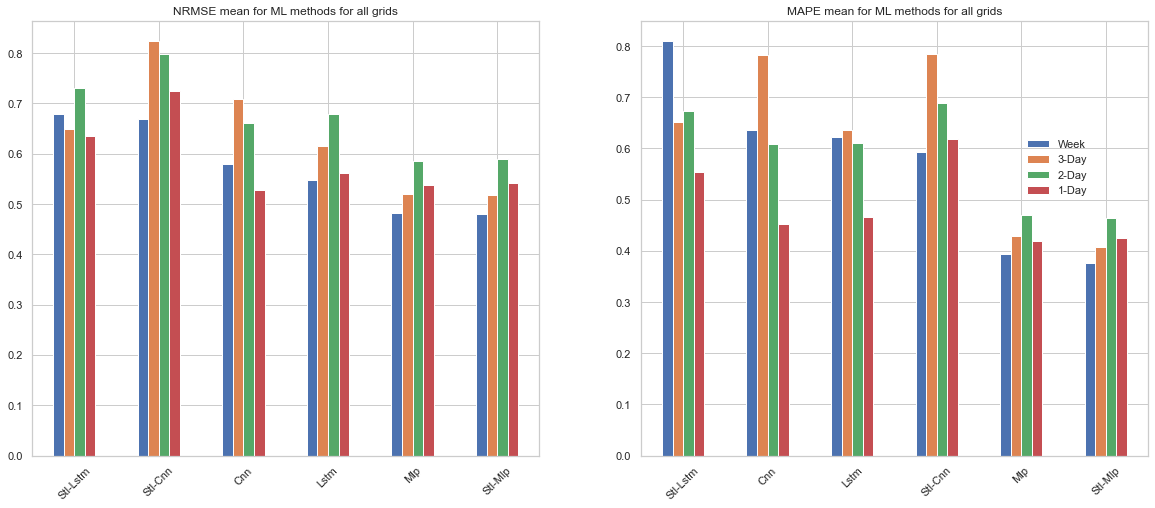

In [80]:
#extract column level
days = set(grids_dl_errors.columns.get_level_values(0))
#extract mean values (mean ± std)
temp = grids_dl_errors.apply(lambda x: x.str.split('±').str[0]).astype(float)
#create a figure
figure, axes = plt.subplots(1, 2)
(
    pd.DataFrame([temp[d]['NRMSE'] for d in days], index=days).T
    .sort_values('Week', ascending=False)
    .plot(kind='bar',
          grid=True,
          ax=axes[0],
          rot='45',
          legend=False,
          layout=(4, 3),
          title='NRMSE mean for ML methods for all grids',
          figsize=(20,8))
)
(
    pd.DataFrame([temp[d]['MAPE'] for d in days], index=days).T
    .sort_values('Week', ascending=False)
    .plot(kind='bar',
          grid=True,
          ax=axes[1],
          rot='45',
          layout=(4, 3),
          title='MAPE mean for ML methods for all grids',
          figsize=(20,8))
    .legend(bbox_to_anchor=(0.9,0.75))
);

#### Box plot for Grid's Errors

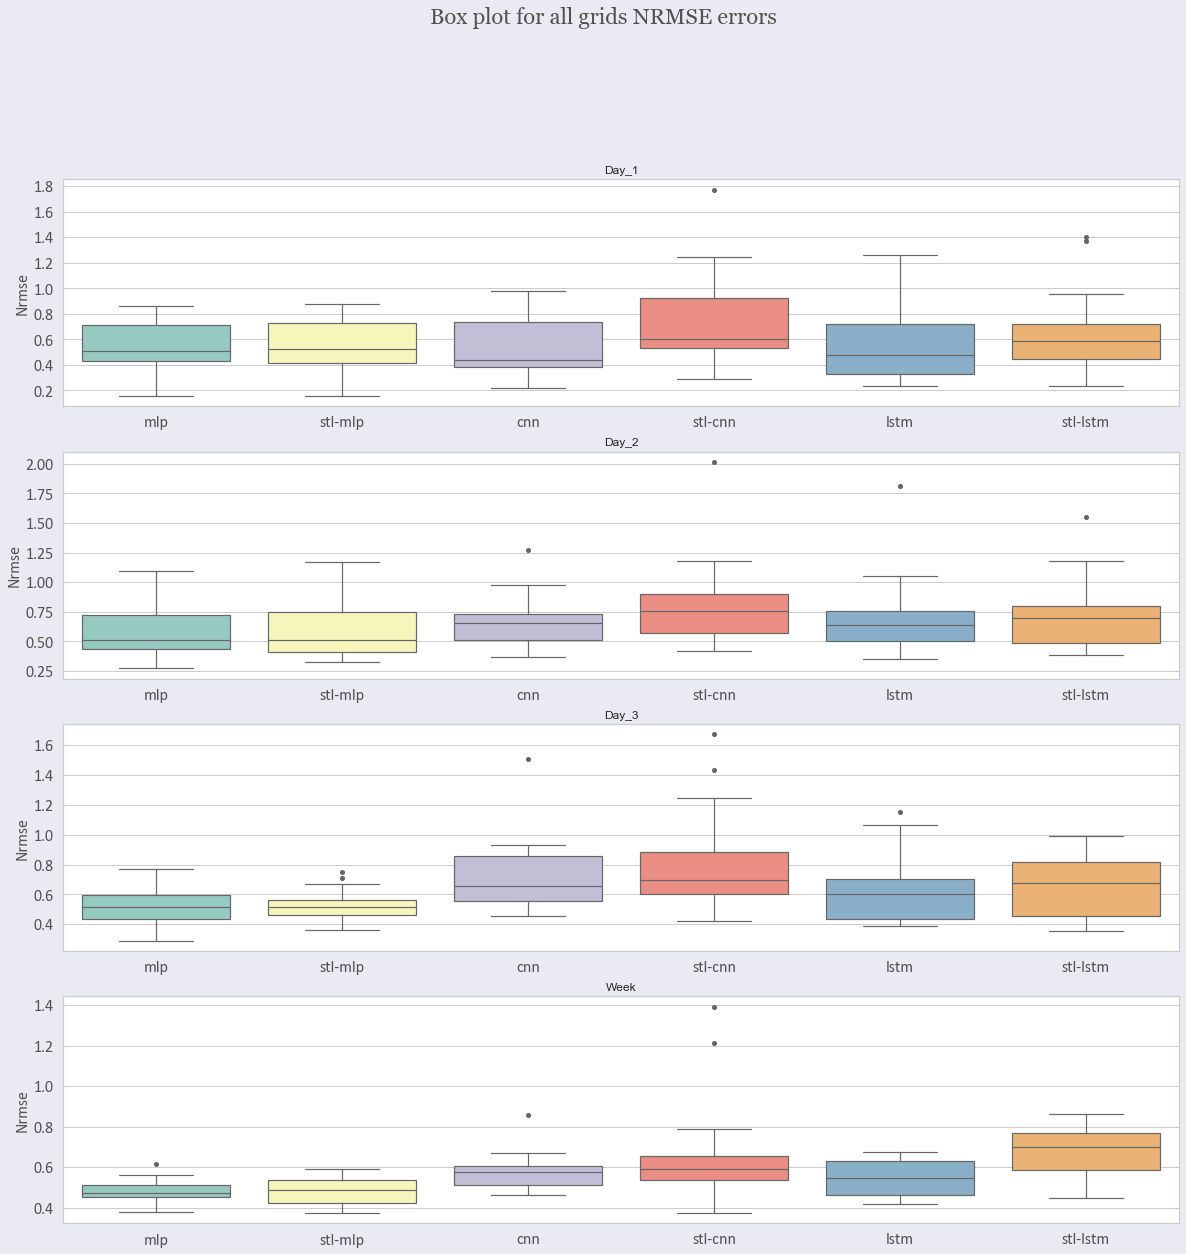

In [25]:
errors_box({'Grid(50,56)':DL_Results['Grid(50,56)']}, 'nrmse')

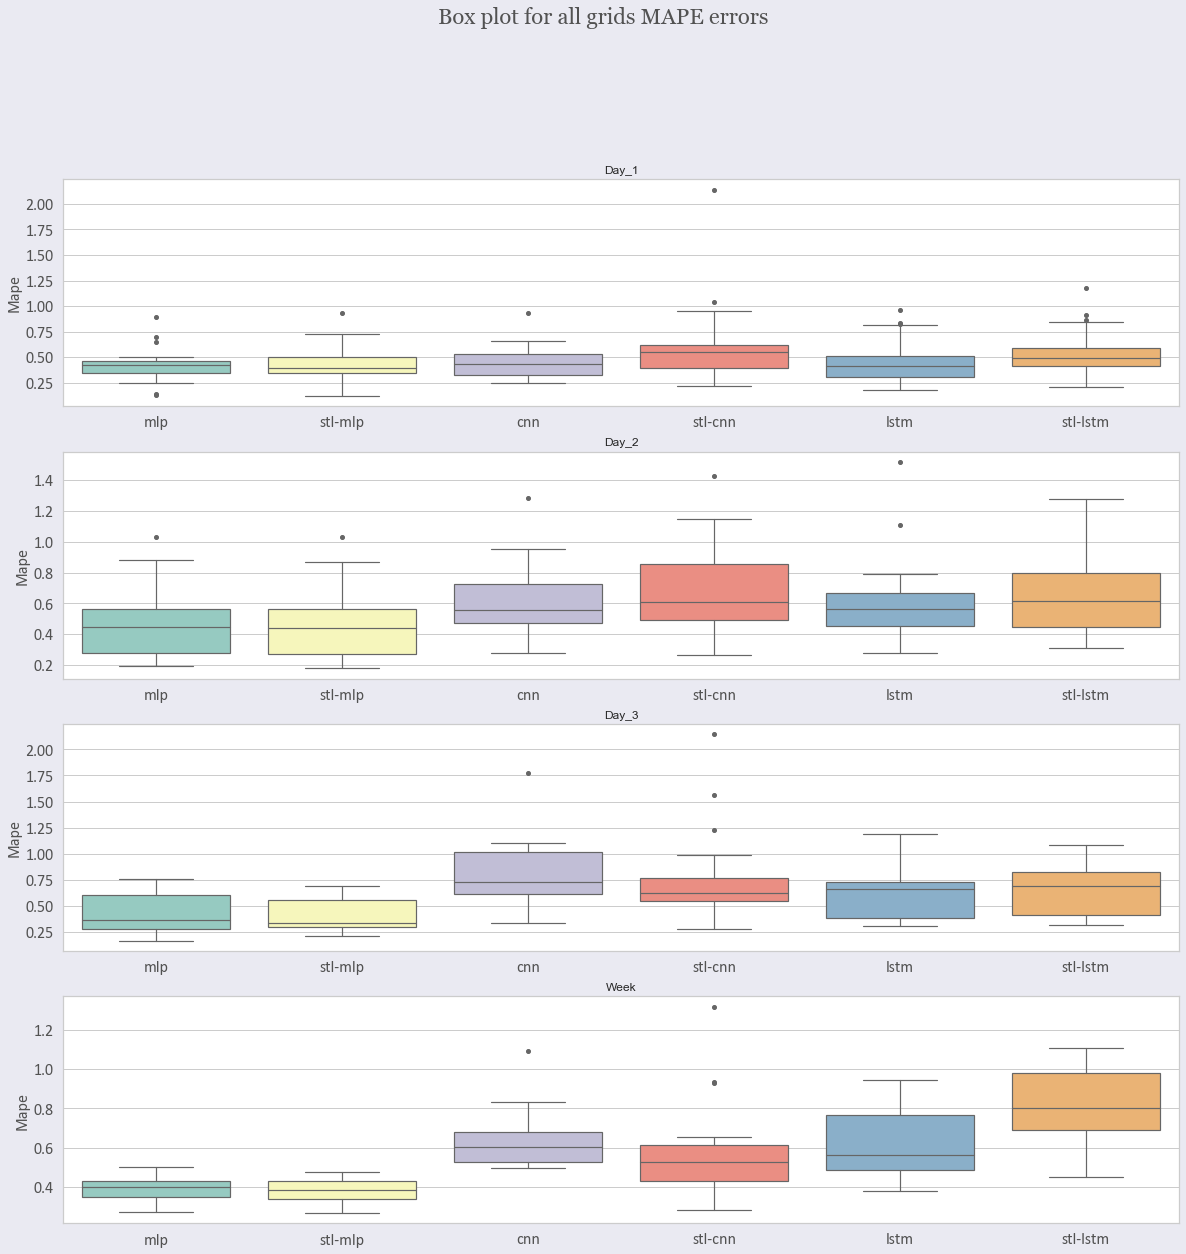

In [26]:
errors_box({'Grid(50,56)':DL_Results['Grid(50,56)']}, 'mape')

> **So, Seasonal Adjustment does not enhance the performance of the forecasting when applying the deeplearning algorithms.**<br><br>
> **See** : <a href="https://www.mdpi.com/2673-4591/5/1/42/pdf">STL Decomposition of Time Series Can Benefit Forecasting Done
by Statistical Methods but Not by Machine Learning Ones</a>

**The major drawback of these methods in handling spatio-temporal data is that no spatial information is encoded.**

### Dealing with the data as a Panel data

Panel data is also called longitudinal data as it adds a temporal dimension to cross-sectional data.

The previous methods to solve this problem consider each grid as a `separate timeseries` and predict the future values of each timeseries using the past values of the same timeseries.

These methods ignores the `spacial dependency` of the traffic of one grid on the neighboring grids.

#### Statistical Methods:
- VAR
- PanelOLS
- RandomEffects
- BetweenOLS
- FirstDifferenceOLS
- PooledOLS
- FamaMacBeth
- Pooled coefficient estimator for panel data

#### DL Methods:
- ConvLSTM
- CNN-LSTM

#### Correlation
- The basis behind Panel data forecasting is that each of the time series in the data influences each other.<br>
- That is, you can predict the series with past values of itself along with other series in the system.<br>
- So, we need to test this relationship before even building the models.

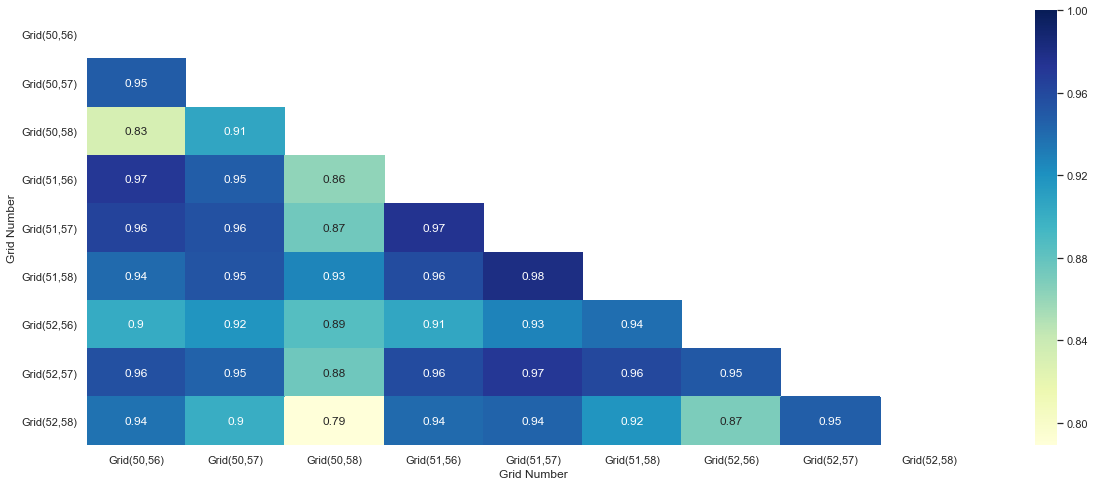

In [60]:
#correlation heatmap
corr = all_df.corr()
# creating the figure
plt.figure(figsize=(20,8))
# creating mask
mask = np.triu(np.ones_like(corr))
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(corr, cmap="YlGnBu", annot=True, mask=mask)
plt.xlabel('Grid Number')
plt.ylabel('Grid Number');

### 1) VAR Model

In [14]:
window_size = 30
date_iter = (full_data.shape[0]//144) - window_size
day_1 = date_iter - 1

models = ['var','stl-var']

VAR_Results = {'Grid(%d,%d)'%(grid[0], grid[1]):
                 {'%s'%model : 
                  {'Day_1':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1)},
                   'Day_2':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-1)},
                   'Day_3':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-2)},
                   'Week' :{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-6)}}
                  for model in models}
                 for grid in forecast_grids}


with catch_warnings():

    filterwarnings("ignore")

    # iterating over the last 32 days
    for i in range(0, date_iter-1, 1):
        # sliding window
        print('        ','='*30,'        ')            
        print('==================== Window %d ===================='%(i+1))
        print('        ','='*30,'        \n')

        # divide the data
        data = divide_data(i, all_df, day_1)

        #### 1-Day forecasting
        print(str('='*30).center(50))            
        print('====== 1-Day  ======'.center(50))
        print(str('='*30).center(50),'\n') 

        print('====== VAR  ======'.center(50))
        VAR_Results = VAR_model(data, VAR_Results, 'Day_1', 'var', i)

        print(' ==== STL-VAR =====\n'.center(50))
        VAR_Results = VAR_model(data, VAR_Results, 'Day_1', 'stl-var', i)

        #### 2-Day forecasting
        if i < (day_1-1):
            print(str('='*30).center(50))            
            print('====== 2-Day  ======'.center(50))
            print(str('='*30).center(50),'\n')

            print('====== VAR  ======'.center(50))
            VAR_Results = VAR_model(data, VAR_Results, 'Day_2', 'var', i)

            print(' ==== STL-VAR =====\n'.center(50))
            VAR_Results = VAR_model(data, VAR_Results, 'Day_2', 'stl-var', i)

        #### 3-Day forecasting
        if i < (day_1-2):
            print(str('='*30).center(50))            
            print('====== 3-Day  ======'.center(50))
            print(str('='*30).center(50),'\n')

            print('====== VAR  ======'.center(50))
            VAR_Results = VAR_model(data, VAR_Results, 'Day_3', 'var', i)

            print(' ==== STL-VAR =====\n'.center(50))
            VAR_Results = VAR_model(data, VAR_Results, 'Day_3', 'stl-var', i)

        #### week forecasting
        if i < (day_1-6):
            print(str('='*30).center(50))            
            print('====== Week  ======'.center(50))
            print(str('='*30).center(50),'\n') 
            
            print('====== VAR  ======'.center(50))
            VAR_Results = VAR_model(data, VAR_Results, 'Week', 'var', i)

            print(' ==== STL-VAR =====\n'.center(50))
            VAR_Results = VAR_model(data, VAR_Results, 'Week', 'stl-var', i)

==================== Window 1 ====================

               ====== 1-Day  ======               

                ====== VAR  ======                
                ==== STL-VAR =====
               
               ====== 2-Day  ======               

                ====== VAR  ======                
                ==== STL-VAR =====
               
               ====== 3-Day  ======               

                ====== VAR  ======                
                ==== STL-VAR =====
               
               ====== Week  ======                

                ====== VAR  ======                
                ==== STL-VAR =====
               
==================== Window 2 ====================

               ====== 1-Day  ======               

                ====== VAR  ======                
                ==== STL-VAR =====
               
               ====== 2-Day  ======               

                ====== VAR  ======                
                ==== ST

In [15]:
# a_file = open("Models Results/VAR_Results.pkl", "wb")
# pickle.dump(VAR_Results, a_file)
# a_file.close()
file = open("Models Results/VAR_Results.pkl", "rb")
VAR_Results = pickle.load(file)
# print(Results)
file.close()

### Errors Visualization

#### Errors Table

In [16]:
grids_var_errors = dict_to_dataframe(VAR_Results, forecast_grids)

In [17]:
pd.set_option('display.float_format', '{:0.9}'.format)
grids_var_errors.sort_values(by=('Week','MAPE'))

1-Day                             2-Day                   \
                    MAPE            NRMSE             MAPE            NRMSE   
Var      0.7167 ± 0.2235  0.7647 ± 0.1644  1.0265 ± 0.3511  0.7797 ± 0.1007   
Stl-Var  0.8095 ± 0.2676  0.7496 ± 0.1525  1.0258 ± 0.3508   0.7793 ± 0.101   

                   3-Day                              Week                   
                    MAPE            NRMSE             MAPE            NRMSE  
Var      1.0405 ± 0.3191  0.7965 ± 0.0923  1.3004 ± 0.3687  0.7902 ± 0.0784  
Stl-Var  1.0405 ± 0.3191  0.7965 ± 0.0923  1.3004 ± 0.3687  0.7902 ± 0.0784

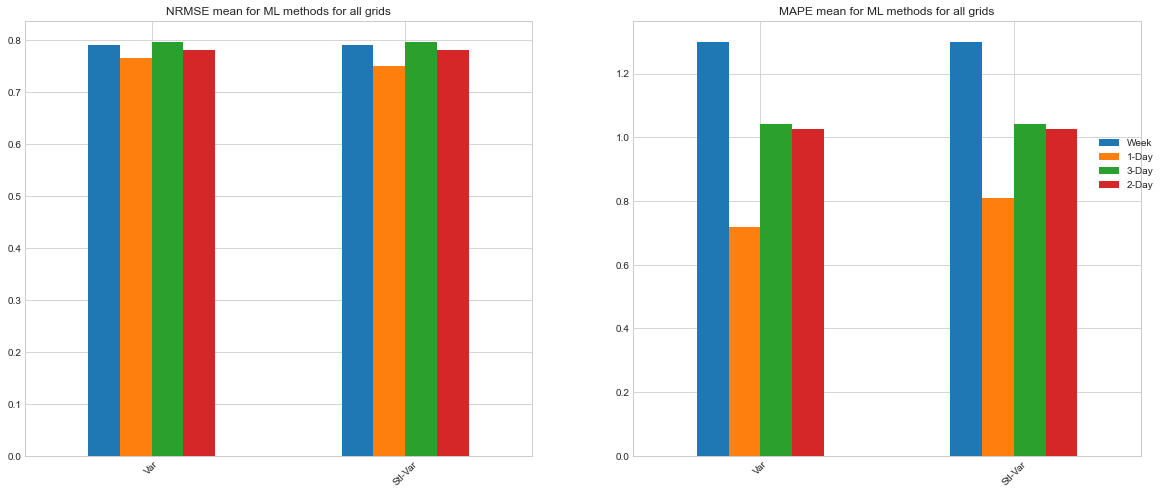

In [18]:
#extract column level
days = set(grids_var_errors.columns.get_level_values(0))
#extract mean values (mean ± std)
temp = grids_var_errors.apply(lambda x: x.str.split('±').str[0]).astype(float)
#create a figure
figure, axes = plt.subplots(1, 2)
(
    pd.DataFrame([temp[d]['NRMSE'] for d in days], index=days).T
    .sort_values('Week', ascending=False)
    .plot(kind='bar',
          grid=True,
          ax=axes[0],
          rot='45',
          legend=False,
          layout=(4, 3),
          title='NRMSE mean for ML methods for all grids',
          figsize=(20,8))
)
(
    pd.DataFrame([temp[d]['MAPE'] for d in days], index=days).T
    .sort_values('Week', ascending=False)
    .plot(kind='bar',
          grid=True,
          ax=axes[1],
          rot='45',
          layout=(4, 3),
          title='MAPE mean for ML methods for all grids',
          figsize=(20,8))
    .legend(bbox_to_anchor=(0.9,0.75))
);

#### Box plot for Grid's Errors

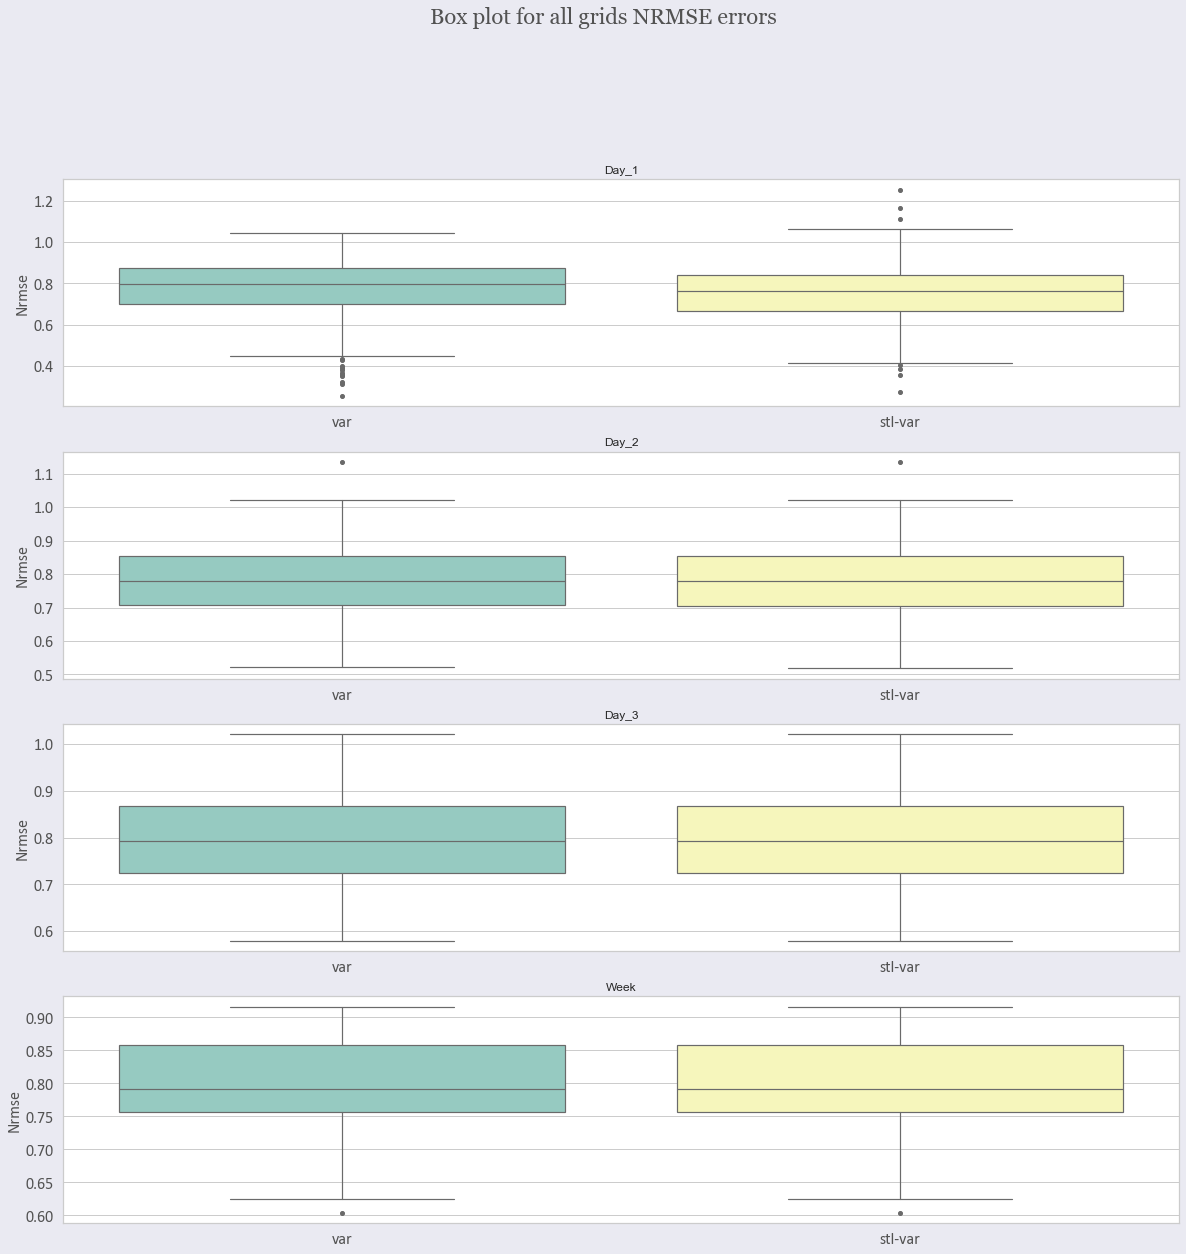

In [12]:
errors_box(VAR_Results, 'nrmse')

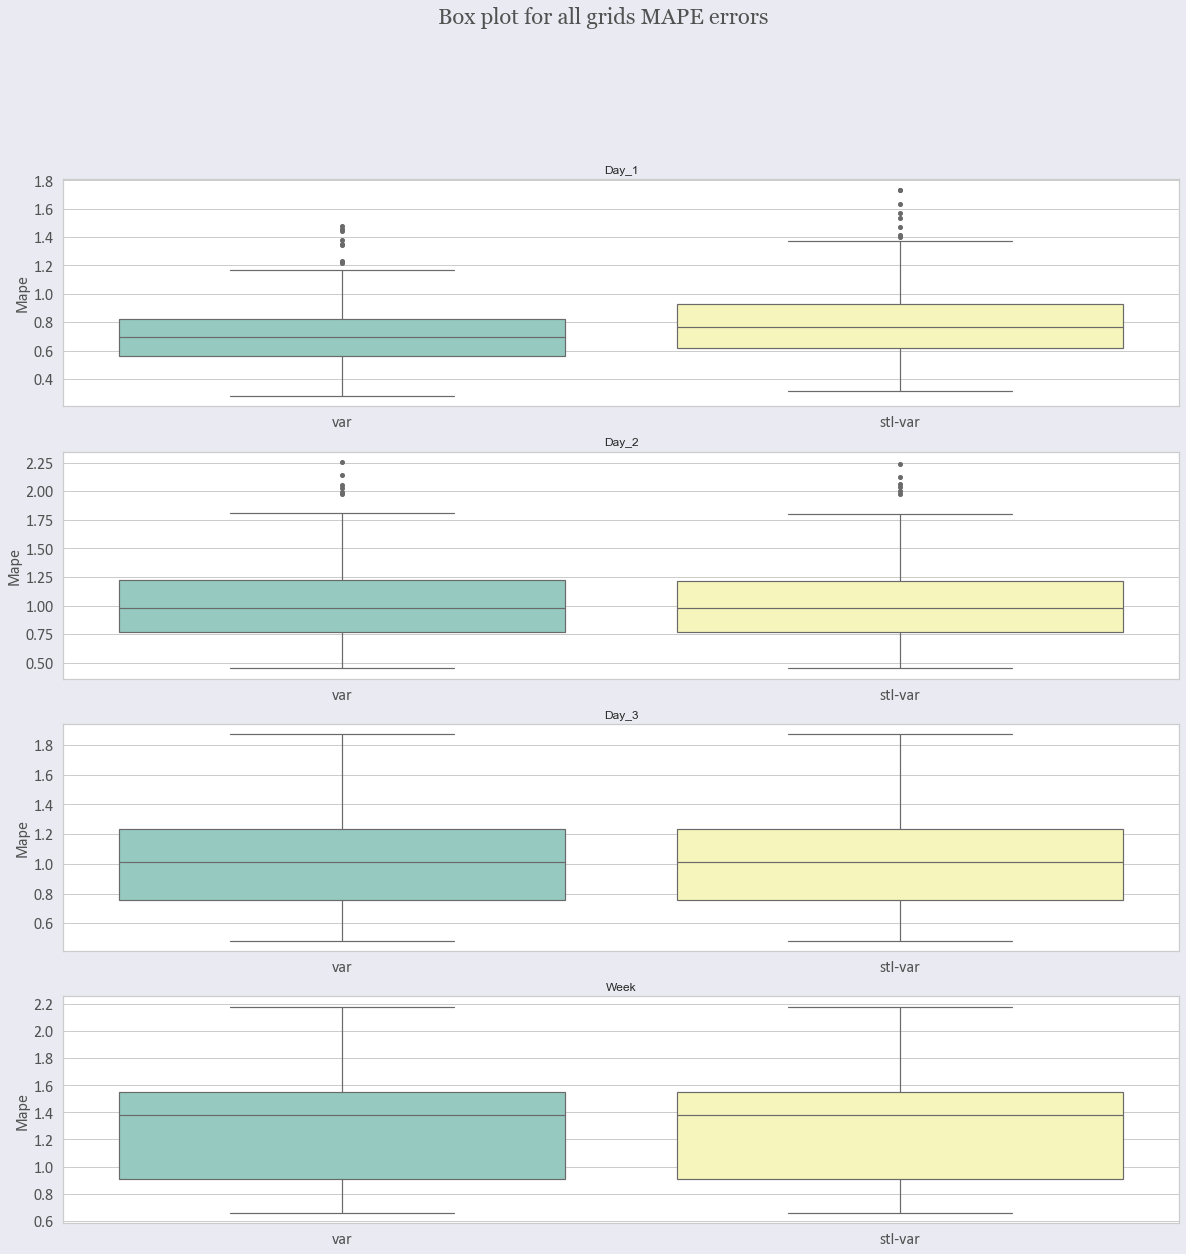

In [13]:
errors_box(VAR_Results, 'mape')

### All Results

In [216]:
pd.set_option('display.float_format', '{:0.9}'.format)

(
    pd.concat([grids_ml_errors, 
               grids_var_errors,  
               grids_stat_errors])
    .sort_values(by=('Week','MAPE'))
)

1-Day                    \
                                       MAPE             NRMSE   
Knn                         0.3541 ± 0.3909  0.47388 ± 0.5311   
Theta                       0.4024 ± 0.3873   0.5464 ± 0.4569   
Stl-Knn                    0.40965 ± 0.4803  0.52906 ± 0.5884   
Stl-Theta                    0.4267 ± 0.443   0.5054 ± 0.5408   
Stl-Lasso                  0.41823 ± 0.3737  0.51352 ± 0.4171   
Stl-Elasticnet             0.41823 ± 0.3737  0.51352 ± 0.4171   
Stl-Linearregression       0.41823 ± 0.3737  0.51352 ± 0.4171   
Stl-Svr                    0.43949 ± 0.4405  0.51637 ± 0.4862   
Svr                        0.53622 ± 0.2193  0.67748 ± 0.2128   
Linearregression           0.54641 ± 0.4253  0.51279 ± 0.4077   
Elasticnet                 0.54682 ± 0.4255  0.51282 ± 0.4078   
Lasso                      0.54682 ± 0.4255  0.51282 ± 0.4078   
Stl-Arima                     0.6899 ± 0.42   0.5691 ± 0.3916   
Var                         0.7167 ± 0.2235   0.7647 ± 0.1644   
Stl-Var                     0.8095 ± 0.2676   0.7496 ± 0.1525   
Arima                       0.9439 ± 0.5866   0.6416 ± 0.3655   
Stl-Exponential Smoothing   0.8588 ± 0.8411   0.8464 ± 0.8262   
Exponential Smoothing       0.9425 ± 1.1152   0.9896 ± 1.0754   

                                      2-Day                    \
                                       MAPE             NRMSE   
Knn                        0.31841 ± 0.3364   0.4129 ± 0.4118   
Theta                        0.398 ± 0.2999   0.4898 ± 0.2609   
Stl-Knn                    0.38014 ± 0.4464  0.47837 ± 0.5006   
Stl-Theta                   0.4121 ± 0.3325   0.4283 ± 0.3021   
Stl-Lasso                  0.39261 ± 0.3437  0.46998 ± 0.3334   
Stl-Elasticnet             0.39261 ± 0.3437  0.46998 ± 0.3334   
Stl-Linearregression       0.39261 ± 0.3437  0.46998 ± 0.3334   
Stl-Svr                     0.41589 ± 0.407  0.47282 ± 0.3958   
Svr                        0.53314 ± 0.2216  0.68099 ± 0.2139   
Linearregression            0.52078 ± 0.402  0.46762 ± 0.3151   
Elasticnet                  0.52115 ± 0.402  0.46763 ± 0.3151   
Lasso                       0.52115 ± 0.402  0.46763 ± 0.3151   
Stl-Arima                   0.7874 ± 0.4123   0.5718 ± 0.2873   
Var                         1.0265 ± 0.3511   0.7797 ± 0.1007   
Stl-Var                     1.0258 ± 0.3508    0.7793 ± 0.101   
Arima                       1.0734 ± 0.5487    0.636 ± 0.2078   
Stl-Exponential Smoothing   1.0956 ± 1.2764   0.8705 ± 0.8031   
Exponential Smoothing       1.5305 ± 2.0826   1.1958 ± 1.3583   

                                      3-Day                    \
                                       MAPE             NRMSE   
Knn                         0.30355 ± 0.329   0.39812 ± 0.411   
Theta                       0.3999 ± 0.2454   0.4819 ± 0.1995   
Stl-Knn                    0.36309 ± 0.4432  0.46178 ± 0.5033   
Stl-Theta                     0.41 ± 0.2636    0.4107 ± 0.205   
Stl-Lasso                   0.38186 ± 0.342   0.46241 ± 0.337   
Stl-Elasticnet              0.38186 ± 0.342   0.46241 ± 0.337   
Stl-Linearregression        0.38185 ± 0.342   0.46241 ± 0.337   
Stl-Svr                    0.40302 ± 0.4017  0.46168 ± 0.3966   
Svr                         0.53628 ± 0.221  0.68654 ± 0.2131   
Linearregression           0.51125 ± 0.4048  0.46185 ± 0.3194   
Elasticnet                  0.5116 ± 0.4047  0.46187 ± 0.3193   
Lasso                       0.5116 ± 0.4047  0.46187 ± 0.3193   
Stl-Arima                    0.844 ± 0.3608   0.5829 ± 0.1923   
Var                         1.0405 ± 0.3191   0.7965 ± 0.0923   
Stl-Var                     1.0405 ± 0.3191   0.7965 ± 0.0923   
Arima                       1.1513 ± 0.4958   0.6562 ± 0.1618   
Stl-Exponential Smoothing   1.4116 ± 1.9782   0.9872 ± 1.1138   
Exponential Smoothing       2.0712 ± 2.9357   1.4326 ± 1.6809   

                                       Week                    
                                       MAPE             NRMSE  
Knn    

### 2) ConvLSTM

**I'm still struggling with this algorithm, so it's not the final work !**

In [231]:
#DL libraries
import keras
from keras import Model, regularizers
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import (Dense, Dropout, Input, concatenate, Conv1D, MaxPooling1D, MaxPooling1D, ConvLSTM2D,
                          Flatten, BatchNormalization, LSTM, Bidirectional, TimeDistributed,)

class ConvLSTM:
    """
    This class creates and train a DL model for univariate TS.
    ...
    Attributes
    ----------
    training : Pandas dataframe
    Data to fit the model with.
    
    algorrithm : str
    Type of DL algorithm (MLP, CNN, LSTM)
    
    lstm_method : str
    If using LSTM model, you need to specify the type of LSTM. 
    (Vanila, Stacked, Bidirectional LSTM, CNN-LSTM, ConvLSTM)
    """
    def __init__(self, training, h, w):
        # save sequence, index
        self.sequence = training.values.reshape(-1, h, w)
        self.index = training.index
        self.shape = self.sequence.shape
        self.h = h
        self.w = w
        
    # make dataset to input
    def build_dataset(self, data, train_test=False):
        self.X = []
        self.y = []
        for i in range(0, data.shape[0] - (self.n_steps_in + self.n_steps_out)):
            _x = data[i : i+self.n_steps_in,...]
            _y = data[i+self.n_steps_in : i+self.n_steps_in+self.n_steps_out,...]
            self.X.append([_x])
            self.y.append([_y])
        
        self.X, self.y = np.array(self.X), np.array(self.y)
        self.y = self.y.reshape(self.y.shape[0], -1)
#         .reshape(-1, self.shape[-1]*self.shape[-2])
        
        # scaling the data 
        if self.is_scale:
            self.X, self.y = self.scale_data(self.X, self.y)
        
        # Split data using train proportion of (70% - 30%)
        if train_test:
            self.split_point = int(0.7 * len(self.X)) 
            self.X_train, self.X_test = self.X[:self.split_point], self.X[self.split_point:]
            self.y_train, self.y_test = self.y[:self.split_point], self.y[self.split_point:]            
            return self.X_train, self.X_test, self.y_train, self.y_test
        
        return self.X, self.y
    
    def scale_data(self, X, y):
        # scale x
        self.scaler_features = MinMaxScaler().fit(X.reshape(-1, 1))
        self.scaled_features = self.scaler_features.transform(X.reshape(-1, 1)).reshape(np.shape(X))
        # scale y
        self.scaler_label = MinMaxScaler().fit(np.array(y.reshape(-1, 1)))
        self.scaled_label = self.scaler_label.transform(y.reshape(-1, 1)).reshape(np.shape(y))
        # return scaled values
        return self.scaled_features, self.scaled_label

    def build(self, n_steps_in, n_steps_out, 
              units=100, batch=256, lr=0.03, 
              kernel_size=(2,2), activation='tanh',
              epochs=100, is_scale=False, verbose=0,
              filter_num=32, pool_size=2):

        # define model parameters
        self.lr = lr
        self.units = units
        self.batch = batch
        self.epochs = epochs
        self.activation = activation
        self.is_scale = is_scale
        self.n_steps_in =  n_steps_in
        self.n_steps_out = n_steps_out
        self.filter_num = filter_num
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.kernel_size = kernel_size

        # split the sequence into samples
        self.X_train, self.X_test, self.y_train, self.y_test = self.build_dataset(self.sequence, True)  
        
        # build the model
        self.model = Sequential()
        self.model.add(BatchNormalization())
        self.model.add(ConvLSTM2D(filters=self.filter_num, 
                                  kernel_size=self.kernel_size, 
                                  activation=self.activation, #return_sequences=True,
                                             # Batch_Samples, frames, Channels, Width, Hight
                                  input_shape=(None, self.shape[-3],  self.shape[-2], self.shape[-1]))) 
        self.model.add(BatchNormalization())
        # self.model.add(keras.layers.MaxPooling3D())
        # self.model.add(ConvLSTM2D(filters=32, kernel_size=(1,1), activation='sigmoid'))
        # self.model.add(BatchNormalization())
        # self.model.add(keras.layers.MaxPooling2D())
        self.model.add(Flatten())
#         self.model.add(Dense(2048, activation='relu'))
#         self.model.add(BatchNormalization())
#         self.model.add(Dropout(0.2))
        self.model.add(Dense(self.units, activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.2))
        self.model.add(Dense(self.n_steps_out*self.shape[-1]*self.shape[-2]))
        
        # callback
        callback = [keras.callbacks.EarlyStopping(patience=5, verbose=0),    #EarlyStopping
                    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=0)] #lr Decaying
        
        # define the optimizer
        opt = Adam(learning_rate=self.lr)
        
        # Compile model
        self.model.compile(optimizer=opt, loss='mse')
        
        # fit the model to the data
        self.history = self.model.fit(x=self.X_train, y=self.y_train, 
                                      validation_data=(self.X_test, self.y_test),
                                      batch_size=self.batch, 
                                      callbacks=callback, 
                                      epochs=self.epochs, 
                                      verbose=verbose)
    
    def forecast(self, data):
        index = data.index
        data = data.values.reshape(-1, self.h, self.w)
        X, y = self.build_dataset(data)
        # prediction
        # (num ot testing samples, shape of single training instance)
        pred = self.model.predict(np.array(X)).flatten()
        #rescale
        if self.is_scale:    
            pred = self.scaler_label.inverse_transform([pred.flatten()])
        return (pred, y)

In [223]:
data = all_df.set_index('time')
split_point = int(0.7 * len(data))
data_train, data_test = data[:split_point], data[split_point:]

In [224]:
# Create instance
model = ConvLSTM(training=data_train, h=3, w=3)

In [227]:
# build and train ConvLSTM model 
model.build(n_steps_in=15, 
            n_steps_out=6,
            units=2048, 
            batch=64, 
            kernel_size=(2,2),
            activation='elu', 
            lr=0.002,
            epochs=100, 
            is_scale=True, 
            verbose=1, 
            filter_num=128, 
            pool_size=2)

Epoch 1/100
58/58 [==============================] - 13s 167ms/step - loss: 1.5729 - val_loss: 0.0402 - lr: 0.0020
Epoch 2/100
58/58 [==============================] - 9s 151ms/step - loss: 0.4647 - val_loss: 0.0385 - lr: 0.0020
Epoch 3/100
58/58 [==============================] - 9s 150ms/step - loss: 0.4194 - val_loss: 0.0485 - lr: 0.0020
Epoch 4/100
58/58 [==============================] - 9s 151ms/step - loss: 0.3612 - val_loss: 0.0660 - lr: 0.0020
Epoch 5/100
58/58 [==============================] - 9s 157ms/step - loss: 0.3071 - val_loss: 0.0270 - lr: 2.0000e-04
Epoch 6/100
58/58 [==============================] - 9s 163ms/step - loss: 0.2883 - val_loss: 0.0236 - lr: 2.0000e-04
Epoch 7/100
58/58 [==============================] - 9s 158ms/step - loss: 0.2807 - val_loss: 0.0203 - lr: 2.0000e-04
Epoch 8/100
58/58 [==============================] - 9s 161ms/step - loss: 0.2790 - val_loss: 0.0142 - lr: 2.0000e-04
Epoch 9/100
58/58 [==============================] - 9s 158ms/step - lo

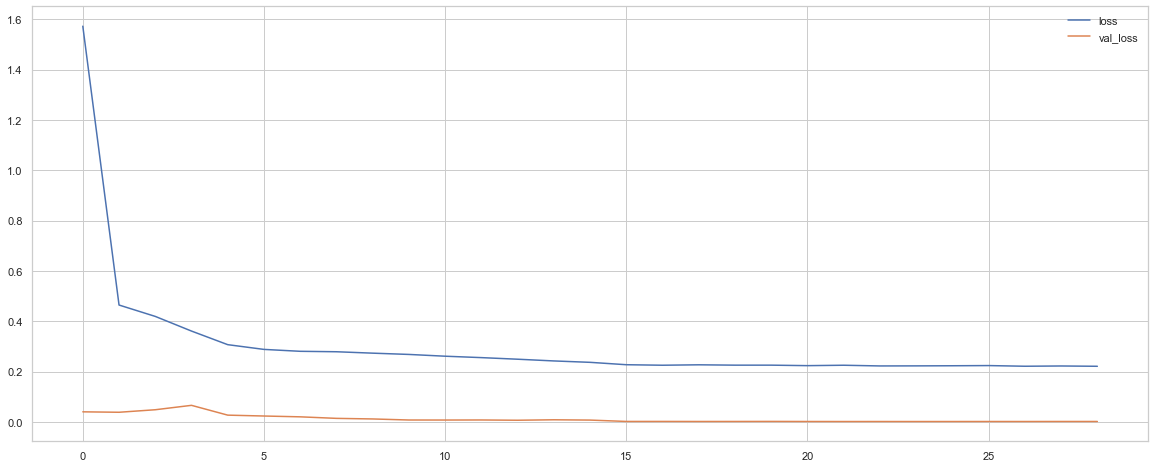

In [229]:
(
    pd.DataFrame(model.history.history)
    [['loss','val_loss']]
    .plot(kind='line', figsize=(20,8))
);

In [232]:
# pred, actual = model.forecast(data_test)